# Project 04 - Identify Fraud from Enron Email

##### Student Tags

Author: Anderson Hitoshi Uyekita    
Project: Identify Fraud from Enron Email    
Course: Data Science - Foundations II  
COD: ND111  
Date: 12/02/2019    
Version: 3.0

***

# Synopsis

In this project, I have yielded several simulations using a variety of classifiers and sets of features. The classifier chose as the final solution is the Decision Trees, which have reached the following metrics:

* Classifier: Decision Trees;
* Precision: 0.39342;
* Recall: 0.82500, and;
* Accuracy: 0.80707.

The procedure of feature selection was compounded by two steps: an exhaustive search using the `SelectKBest`, which has performed the univariate feature selection, and later filtering the remaining features selected by `SelectKBest` by low NaN proportion. After that, I have run several simulations using different classifiers to evaluate two sets of features (the original set of features and an alternative with engineered features aggregated). I have ended up choosing the set of features with the engineered feature due to the overall better results.

To accomplish the threshold of 0.3 for precision and recall, I have simulated several classifiers but this time tuning the parameters values to achieve better metrics. In the process of tuning, I have used the `GridSearchCV` together with the `Pipeline`.

In order to avoid overfitting, I have used in all simulation the `StratifiedShuffleSplit`, which divides the dataset into training and test. Also, preserves the labels proportion while shuffling the `n_splits` simulations.

Finally, by using the `test_classifier` function from `tester.py`, three classifiers have reached the threshold: AdaBoost, Random Forest, and Decision Trees. However, Decision Trees has the highest recall metric, which I believe is the most important metric for this kind of model that aims to identify POI (a very scarce label).
***

## Table of Contents
- [1. Introduction](#intro)
- [2. Data Wrangling](#wrangling)
    - [2.1. Data Gathering](#gathering)
    - [2.2. Data Assessing](#assessing)
    - [2.3. Data Cleaning](#cleaning)
        - [**Task 2** - Removing Outliers](#task2)    
    - [2.4. Exporing to JSON](#exporting)
- [3. Exploratory Data Analysis](#eda)
    - [3.1. Tableau Public](#story)
    - [3.2. Feature Engineering](#feature_engineering)
        - [**Task 3** - Creating new features](#task3)    
    - [3.3. Feature Scaling](#scaling)
    - [3.4. Feature Selection](#selection)
        - [3.4.1.  Evaluating Sets of Features](#fatures_evaluation)
        - [**Task 1** - Feature List](#task1)
        - [**Task 4** - Try a varity of classifiers](#task4)    
    - [3.5. Dimension Reduce](#pca)        
- [4. Predicting](#predicting)
    - [4.1. Tuning Parameters](#tuning)
    - [4.2. Classifier Evaluation - Optimized Parameters](#evaluating_classifiers)
        - [**Task 5** - Tune your classifier](#task5)
        - [**Task 6** - Dump your classifier, dataset, and features_list](#task6)
- [5. Conclusions](#conclusions)
- [6. Questions](#questions)
- [References](#references)
- [Appendix](#appendix)
    - [Given code](#code)



***

# 1. Introduction <a id='intro'></a>

I have decided to use the Jupyter Notebook due to several reasons:

* Record the data manipulation;
* Data Wrangling;
* Data Visualization, and;
* Perform a Reproducible Research.

The original file (`poi_id.py`) was used in several pieces spread all over this document.

### 1.1. Reproducibility

I have written this report using the Jupyter Notebook, which would allow anyone to reproduce this document in a local computer. I have made a great effort to document every step to turn this document understandable.

#### Work envinronment

I have performed this project using:

* Dell Notebook Inspiron 7348;
* Intel(R) Core(TM) i7-5500U CPU @ 2.40GHz 2.40GHz;
* 8.00 GB, and;
* Windows 10 Pro 64-bits.

#### Softwares

This report has written using four software:

* Python (version 2.7.15);
* Jupyter Notebook (version 5.6.0);
* Tableau Desktop Public (version 2018.3.2 - 20183.18.1219.1533 - 64-bits);
* Opera (version 58.0.3135.47), and;
* Atom (version 1.34.1 ia32).

I have used the Atom to push it to a Github repository and minor changes.

[version_information_github]: https://github.com/jrjohansson/version_information

#### Repository

I kindly ask you to install each of these packages before you run the next steps.

* https://github.com/AndersonUyekita/ND111_data_science_foundations_02

#### Path

I have written/coded this report inside of the `ud120-projects/final_project` folder.

### 1.2. Importing Libraries

For this project I will use some libraries to manage data frames, download file, Twitter API Client code, etc.. Let's import these packages to the Jupyter Notebook environment.

In [1]:
# General 
import pandas as pd
import numpy as np
import sklearn
import sys
import pickle
import json
from time import time
import warnings
warnings.filterwarnings("ignore")

# Given code
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
import tester

# Plotting
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns


# Scikit Learn
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler

### 1.3. Questions

Founded on the instructions, I will guide my Jupyter Notebook following the questions posed in the document hosted [here][q_link].

### 1.4. Rubric

Also following the instructions, I will keep in mind to attend all the requirement pointed out in the [rubric][rubric].  

[q_link]: https://docs.google.com/document/d/1NDgi1PrNJP7WTbfSUuRUnz8yzs5nGVTSzpO7oeNTEWA/pub?embedded=true
[rubric]: https://review.udacity.com/#!/rubrics/27/view

***

## 2. Data Wrangling  <a id='wrangling'></a>

I have divided the Data Wrangling process into three smaller steps:

* Data Gathering;
* Data Assessing, and;
* Data Cleaning.

### 2.1. Data Gathering <a id='gathering'></a>

All data from this project, I have forked from the Udacity Github repository. Most parts of the gathering process were already made by the instructor. For this reason, the only task I did was loading the pickle file.

In [2]:
# Task 1: Select what features you'll use.  
# features_list is a list of strings, each of which is a feature name.  
# The first feature must be "poi". 
features_list = ['poi','salary'] # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    
# Data type.
type(data_dict)

dict

The `data_dict` is a dictionary which has all information about the POI and non-POI employee from Enron.

Fortunately, a dictionary is easily converted to Data Frame.

### 2.2. Data Assessing <a id='assessing'></a>

The first step here is to realize what kind of information this dictionary has. So let's extract the keys of this dictionary and later on print the content of each key.

In [3]:
# Initialization of list.
names_key = []

# Loop to gather the keys of this dictionary.
for index in data_dict:
    names_key.append(index)

# Print the first 5 names_key from data_dict.
names_key[:5]

['METTS MARK',
 'BAXTER JOHN C',
 'ELLIOTT STEVEN',
 'CORDES WILLIAM R',
 'HANNON KEVIN P']

The keys are names.

>How many names are in this dictionary?

In [4]:
print "Number of names: ", len(names_key)

Number of names:  146


Now, I want to investigate the value associated with the first key ('METTS MARK').

In [5]:
# Value associated to the names_key.
data_dict['METTS MARK']

{'bonus': 600000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'mark.metts@enron.com',
 'exercised_stock_options': 'NaN',
 'expenses': 94299,
 'from_messages': 29,
 'from_poi_to_this_person': 38,
 'from_this_person_to_poi': 1,
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 1740,
 'poi': False,
 'restricted_stock': 585062,
 'restricted_stock_deferred': 'NaN',
 'salary': 365788,
 'shared_receipt_with_poi': 702,
 'to_messages': 807,
 'total_payments': 1061827,
 'total_stock_value': 585062}

As you can see, there are several variables available to a further study. I will create a dataframe with all the information.

In [6]:
# Converting dictionary in dataframe.
df_dict = pd.DataFrame(data_dict).transpose()

# Printing the first 5 rows.
df_dict.head()

bonus deferral_payments deferred_income director_fees  \
ALLEN PHILLIP K     4175000           2869717        -3081055           NaN   
BADUM JAMES P           NaN            178980             NaN           NaN   
BANNANTINE JAMES M      NaN               NaN           -5104           NaN   
BAXTER JOHN C       1200000           1295738        -1386055           NaN   
BAY FRANKLIN R       400000            260455         -201641           NaN   

                                 email_address exercised_stock_options  \
ALLEN PHILLIP K        phillip.allen@enron.com                 1729541   
BADUM JAMES P                              NaN                  257817   
BANNANTINE JAMES M  james.bannantine@enron.com                 4046157   
BAXTER JOHN C                              NaN                 6680544   
BAY FRANKLIN R             frank.bay@enron.com                     NaN   

                   expenses from_messages from_poi_to_this_person  \
ALLEN PHILLIP K       13868          2195                      47   
BADUM JAMES P          3486           NaN                     NaN   
BANNANTINE JAMES M    56301            29                      39   
BAXTER JOHN C         11200           NaN                     NaN   
BAY FRANKLIN R       129142           NaN                     NaN   

                   from_this_person_to_poi        ...         \
ALLEN PHILLIP K                         65        ...          
BADUM JAMES P                          NaN        ...          
BANNANTINE JAMES M                       0        ...          
BAXTER JOHN C                          NaN        ...          
BAY FRANKLIN R                         NaN        ...          

                   long_term_incentive    other    poi restricted_stock  \
ALLEN PHILLIP K                 304805      152  False           126027   
BADUM JAMES P                      NaN      NaN  False              NaN   
BANNANTINE JAMES M                 NaN   864523  False          1757552   
BAXTER JOHN C                  1586055  2660303  False          3942714   
BAY FRANKLIN R                     NaN       69  False           145796   

                   restricted_stock_deferred  salary shared_receipt_with_poi  \
ALLEN PHILLIP K                      -126027  201955                    1407   
BADUM JAMES P                            NaN     NaN                     NaN   
BANNANTINE JAMES M                   -560222     477                     465   
BAXTER JOHN C                            NaN  267102                     NaN   
BAY FRANKLIN R                        -82782  239671                     NaN   

                   to_messages total_payments total_stock_value  
ALLEN PHILLIP K           2902        4484442           1729541  
BADUM JAMES P              NaN         182466            257817  
BANNANTINE JAMES M         566         916197           5243487  
BAXTER JOHN C              NaN        5634343          10623258  
BAY FRANKLIN R             NaN         827696             63014  

[5 rows x 21 columns]

>How many variables are available?

In [7]:
# Are there how many variables?
print "Variables: ", df_dict.shape[1]

Variables:  21


>How many observations are available?

In [8]:
# Are there how many observations?
print "Observations: ", df_dict.shape[0]

Observations:  146


>How many POI?

In [9]:
# POI?
print "POI:", sum(df_dict.poi)
print "non-POI:", df_dict.shape[0] - sum(df_dict.poi)

POI: 18
non-POI: 128


>What are the variables?

In [10]:
# All variables available to choose.
original_feat = ['poi', 'bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options',
                 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances',
                 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'salary',
                 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']

# Priting all variables.
df_dict.columns.tolist()

['bonus',
 'deferral_payments',
 'deferred_income',
 'director_fees',
 'email_address',
 'exercised_stock_options',
 'expenses',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'loan_advances',
 'long_term_incentive',
 'other',
 'poi',
 'restricted_stock',
 'restricted_stock_deferred',
 'salary',
 'shared_receipt_with_poi',
 'to_messages',
 'total_payments',
 'total_stock_value']

These features could be divided into:


**Other (1):**
* POI.

**Email Features (6):**
* email_address;
* from_messages;
* to_messages;
* from_poi_to_this_person;
* from_this_person_to_poi, and;
* shared_receipt_with_poi.

**Financial Features (14):**
* bonus;
* deferral_payments;
* deferred_income;
* director_fees;
* exercised_stock_options;
* expenses;
* loan_advances;
* long_term_incentive;
* other;
* restricted_stock;
* restricted_stock_deferred;
* salary;
* total_payments, and;
* total_stock_value.

Clearly, this dataframe has a lot of `NaN`. Let's check it.

In [11]:
# Initializing a dictionary to store the NaN proportion.
nan_proportion = dict()

# Loop to create the proportion of NaN per variable.
for index in df_dict.columns.tolist():
    nan_proportion[index] = round(sum(df_dict[index] == 'NaN')/float(len(df_dict[index])), 2)
    
# Converting in pandas DataFrame.
nan_proportion = pd.DataFrame.from_dict(nan_proportion, orient='index', columns = ['nan'])

# Sorting to show the variables with less NaN in the first rows.
nan_proportion = nan_proportion.sort_values('nan')

nan_proportion

nan
poi                        0.00
total_payments             0.14
total_stock_value          0.14
email_address              0.24
restricted_stock           0.25
exercised_stock_options    0.30
salary                     0.35
expenses                   0.35
other                      0.36
from_poi_to_this_person    0.41
from_messages              0.41
from_this_person_to_poi    0.41
to_messages                0.41
shared_receipt_with_poi    0.41
bonus                      0.44
long_term_incentive        0.55
deferred_income            0.66
deferral_payments          0.73
restricted_stock_deferred  0.88
director_fees              0.88
loan_advances              0.97

There are some variable with a high rate of `NaN`, but this is totally acceptable because neither all employee has `director_fees`, `long_term_incentive`, etc. All definition of these variables could be found in the `enron61702insiderpay.pdf`, this document is available in the repository project (`ud120-projects/final_project`).

The definition of two main variables:

* `total_payments`, and;
* `total_stock_value`.

The `total_payments` is a summation of:

* salary;
* bonus;
* long_term_incentive;
* deferred_income;
* deferral_payments;
* loan_advances;
* others;
* expenses, and;
* director_fees.

Figure 1 shows a fragment of the `enron61702insiderpay.pdf` document.  

<br>
<center>
<img src="01-img/nd111_project_04_01.png" alt="Figure 1 - Total Payments Composition" width="80%;" />
<em>Figure 1 - Total Payment composition.
</em>
</center>


The `total_stock_value` is a summation of:

* exercised_stock_options;
* restricted_stock, and;
* retricted_stock_deferred.

Figure 1 shows a fragment of the `enron61702insiderpay.pdf` document.  

<br>
<center>
<img src="01-img/nd111_project_04_02.png" alt="Figure 2 - Total Stock Value Composition" width="40%;" />
<em>Figure 2 - Total Stock Value.
</em>
</center>

As you can see, there are 7 variables without relation with `enron61702insiderpay.pdf`.

* poi;
* email_address;
* from_poi_to_this_person;
* from_messages;
* from_this_person_to_poi;
* to_messages, and;
* shared_receipt_with_poi.

Let's have a look in the features plotting a straightforward scatter plot of `total_payments` and `salary`.

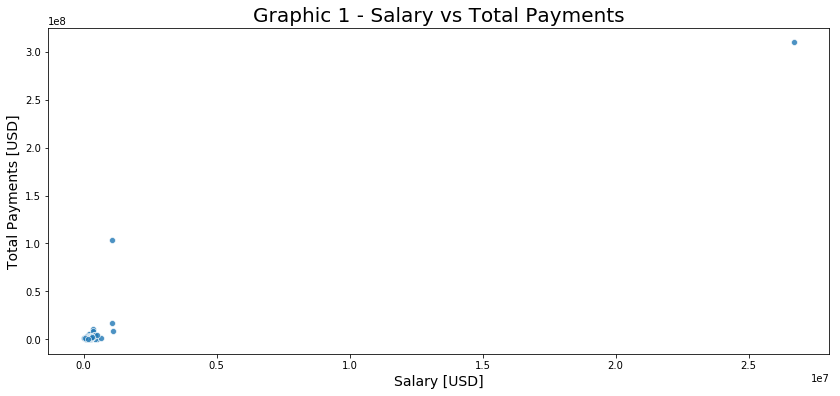

In [12]:
# Visualizing the data.

plt.figure(figsize = [14,6]);                 # Defining the figure size.
sns.scatterplot(x = df_dict.salary,           # X axis feature.
                y = df_dict.total_payments,   # Y axis feature.
                alpha = 0.8);                 # Points transparency.
plt.xlabel('Salary [USD]',                    # X axis label.
           fontsize = 14);                    
plt.ylabel('Total Payments [USD]',            # X axis label.
           fontsize = 14);
plt.title('Graphic 1 - Salary vs Total Payments', # Graphic Title.
          fontsize = 20);

Notable, there is a strange point far from the others, it is possible an outlier. Sorting the dataframe by the `salary` it is a good way to understand it.

In [13]:
# Sorting the salary, only the first 5 rows.
df_dict.query('salary != "NaN"').sort_values('salary', ascending = False)[['salary']].head()

salary
TOTAL               26704229
SKILLING JEFFREY K   1111258
LAY KENNETH L        1072321
FREVERT MARK A       1060932
PICKERING MARK R      655037

Bear in mind, one of this observation is the `TOTAL`, which I should remove from the DataFrame because it is not an observation, it is an aggregate value.

Table 1 shows the problems to be fixed in Data Cleaning.

<br><center><strong>Table 1 - Table of Issues.</strong>

|Issue ID|Issue Type|Dimension|Method|Description|
|:-:|:-:|:-:|:-:|:-:|
|1|Quality|Validity|Visual|Remove the `TOTAL` observation because it is an aggregate information|

</center>

I will check all in features from each employee to compute how many `NaN` are. If any the number of `NaN` reach 20 means that there is no information record for the given employee.

In [14]:
# List to store the values of NaN for each employee. 
employee_nan = []

for index in df_dict.transpose():
    employee_nan.append([index, sum(df_dict.transpose()[index] == 'NaN')])

In [15]:
# Converting the List in DataFrame.
employee_nan = pd.DataFrame(employee_nan, columns = ['Employee','# NaN']).sort_values('# NaN', ascending = False)

# Printing the first 10 rows.
employee_nan.head(10)

Employee  # NaN
84               LOCKHART EUGENE E     20
138                 WHALEY DAVID A     18
56                   GRAMM WENDY L     18
127  THE TRAVEL AGENCY IN THE PARK     18
143                   WROBEL BRUCE     18
53                     GILLIS JOHN     17
142                  WODRASKA JOHN     17
25                 CLINE KENNETH W     17
133                   WAKEHAM JOHN     17
114                   SAVAGE FRANK     17

Without no doubt, the employee `LOCKHART EUGENE E` do not have any information.

In [16]:
# Printing the info from LOCKHART EUGENE E.
df_dict.loc[['LOCKHART EUGENE E']]

bonus deferral_payments deferred_income director_fees  \
LOCKHART EUGENE E   NaN               NaN             NaN           NaN   

                  email_address exercised_stock_options expenses  \
LOCKHART EUGENE E           NaN                     NaN      NaN   

                  from_messages from_poi_to_this_person  \
LOCKHART EUGENE E           NaN                     NaN   

                  from_this_person_to_poi        ...         \
LOCKHART EUGENE E                     NaN        ...          

                  long_term_incentive other    poi restricted_stock  \
LOCKHART EUGENE E                 NaN   NaN  False              NaN   

                  restricted_stock_deferred salary shared_receipt_with_poi  \
LOCKHART EUGENE E                       NaN    NaN                     NaN   

                  to_messages total_payments total_stock_value  
LOCKHART EUGENE E         NaN            NaN               NaN  

[1 rows x 21 columns]

Probably the `THE TRAVEL AGENCY IN THE PARK` is not an employee, and for this reason, I also will remove it.

There are some employees, which needs some further investigation as you can see in the query below.

In [17]:
# Employees without salary and total_stock_value.
df_dict.loc[employee_nan.Employee[:10].tolist()].query('salary == "NaN"').query('total_stock_value == "NaN"')

bonus deferral_payments deferred_income  \
LOCKHART EUGENE E               NaN               NaN             NaN   
GRAMM WENDY L                   NaN               NaN             NaN   
THE TRAVEL AGENCY IN THE PARK   NaN               NaN             NaN   
WODRASKA JOHN                   NaN               NaN             NaN   
WAKEHAM JOHN                    NaN               NaN             NaN   
SAVAGE FRANK                    NaN               NaN         -121284   

                              director_fees            email_address  \
LOCKHART EUGENE E                       NaN                      NaN   
GRAMM WENDY L                        119292                      NaN   
THE TRAVEL AGENCY IN THE PARK           NaN                      NaN   
WODRASKA JOHN                           NaN  john.wodraska@enron.com   
WAKEHAM JOHN                         109298                      NaN   
SAVAGE FRANK                         125034                      NaN   

                              exercised_stock_options expenses from_messages  \
LOCKHART EUGENE E                                 NaN      NaN           NaN   
GRAMM WENDY L                                     NaN      NaN           NaN   
THE TRAVEL AGENCY IN THE PARK                     NaN      NaN           NaN   
WODRASKA JOHN                                     NaN      NaN           NaN   
WAKEHAM JOHN                                      NaN   103773           NaN   
SAVAGE FRANK                                      NaN      NaN           NaN   

                              from_poi_to_this_person from_this_person_to_poi  \
LOCKHART EUGENE E                                 NaN                     NaN   
GRAMM WENDY L                                     NaN                     NaN   
THE TRAVEL AGENCY IN THE PARK                     NaN                     NaN   
WODRASKA JOHN                                     NaN                     NaN   
WAKEHAM JOHN                                      NaN                     NaN   
SAVAGE FRANK                                      NaN                     NaN   

                                     ...        long_term_incentive   other  \
LOCKHART EUGENE E                    ...                        NaN     NaN   
GRAMM WENDY L                        ...                        NaN     NaN   
THE TRAVEL AGENCY IN THE PARK        ...                        NaN  362096   
WODRASKA JOHN                        ...                        NaN  189583   
WAKEHAM JOHN                         ...                        NaN     NaN   
SAVAGE FRANK                         ...                        NaN     NaN   

                                 poi restricted_stock  \
LOCKHART EUGENE E              False              NaN   
GRAMM WENDY L                  False              NaN   
THE TRAVEL AGENCY IN THE PARK  False              NaN   
WODRASKA JOHN                  False              NaN   
WAKEHAM JOHN                   False              NaN   
SAVAGE FRANK                   False              NaN   

                              restricted_stock_deferred salary  \
LOCKHART EUGENE E                                   NaN    NaN   
GRAMM WENDY L                                       NaN    NaN   
THE TRAVEL AGENCY IN THE PARK                       NaN    NaN   
WODRASKA JOHN                                       NaN    NaN   
WAKEHAM JOHN                                        NaN    NaN   
SAVAGE FRANK                                        NaN    NaN   

                              shared_receipt_with_poi to_messages  \
LOCKHART EUGENE E                                 NaN         NaN   
GRAMM WENDY L                                     NaN         NaN   
THE TRAVEL AGENCY IN THE PARK                     NaN         NaN   
WODRASKA JOHN                                     NaN         NaN   
WAKEHAM JOHN                                      NaN         NaN   
SAVAGE FRANK                                      NaN

Although I have a strong reason to remove them, I can not discard it due to the lack of observations.

Table 2 shows all the issues I have found in the dataset.

<br><center><strong>Table 2 - Table of Issues.</strong>

|Issue ID|Issue Type|Dimension|Method|Description|
|:-:|:-:|:-:|:-:|:-:|
|1|Quality|Validity|Visual|Remove the `TOTAL` observation because it is a aggregate information.|
|2|Quality|Validity|Programmatic|Remove the `LOCKHART EUGENE E` observation because it only has `NaN`.|
|3|Quality|Validity|Programmatic|Remove the `THE TRAVEL AGENCY IN THE PARK` observation because it is not an employee.|

</center>

### 2.3. Data Cleaning <a id='cleaning'></a>

Fortunately, there is only one problem pointed out in Data Assessing.

#### Issue ID 1

>**Issue:** Remove the observation `TOTAL`.

**Define**

* Remove from the `data_dict` the key `TOTAL`.

**Code**

In [18]:
# Copying the original dictionary.
data_dict_clean = data_dict.copy()

# Removing the TOTAL key.
data_dict_clean.pop('TOTAL');

**Test**

Visually I can assure the `TOTAL` removal plotting the `salary` by `total_payments`.

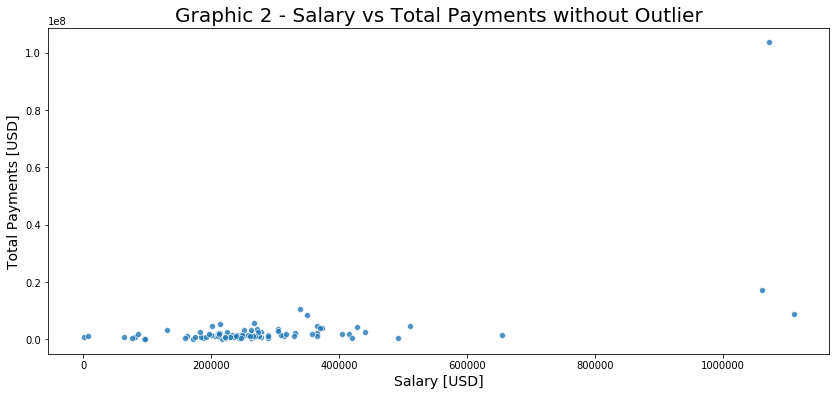

In [19]:
# Creating a dataframe to be used to plot the graphic. This is a temporaly variable.
df_clean = pd.DataFrame(data_dict_clean).transpose()

# Visualizing the data.

plt.figure(figsize = [14,6]);                 # Defining the figure size.
sns.scatterplot(x = df_clean.salary,           # X axis feature.
                y = df_clean.total_payments,   # Y axis feature.
                alpha = 0.8);                 # Points transparency.
plt.xlabel('Salary [USD]',                    # X axis label.
           fontsize = 14);                    
plt.ylabel('Total Payments [USD]',            # X axis label.
           fontsize = 14);
plt.title('Graphic 2 - Salary vs Total Payments without Outlier', # Graphic Title.
          fontsize = 20);

Programmatically I can confirm the exclusion of the `TOTAL` checking the existence in the index.

In [20]:
# Confirming the exclusion of TOTAL from the dataframe.
sum(df_clean.index == 'TOTAL') # 0: removed; 1: Not removed

0

#### Issue ID 2

>**Issue:** Remove the observation `LOCKHART EUGENE E`.

**Define**

* Remove from the `data_dict` the key `LOCKHART EUGENE E`.

**Code**

In [21]:
# Removing the key LOCKHART EUGENE E.
data_dict_clean.pop('LOCKHART EUGENE E');

**Test**

In [22]:
# Temporaly variable only to justify this test.
df_clean = pd.DataFrame(data_dict_clean).transpose()

# Confirming the exclusion of TOTAL from the dataframe.
sum(df_clean.index == 'LOCKHART EUGENE E') # 0: removed; 1: Not removed

0

#### Issue ID 3

>**Issue:** Remove the observation `THE TRAVEL AGENCY IN THE PARK`.

**Define**

* Remove from the `data_dict` the key `THE TRAVEL AGENCY IN THE PARK`.

**Code**

In [23]:
# Removing the key THE TRAVEL AGENCY IN THE PARK.
data_dict_clean.pop('THE TRAVEL AGENCY IN THE PARK');

**Test**

In [24]:
# Temporaly variable only to justify this test.
df_clean = pd.DataFrame(data_dict_clean).transpose()

# Confirming the exclusion of TOTAL from the dataframe.
sum(df_clean.index == 'THE TRAVEL AGENCY IN THE PARK') # 0: removed; 1: Not removed

0

#### Checking Dataframe

I expect to have 143 observations after the cleaning process.

In [25]:
# Number of valid observations. 
print "Number of observations: ", df_clean.shape[0]

Number of observations:  143


### Task 2 - Removing Outliers <a id='task2'></a>

>**Remove outliers**

I have removed the `TOTAL` observation because it is an aggregation. The reason to keep the extreme values from `LAY KENNETH L`, `LAVORATO JOHN J`, `SKILLING JEFFREY K`, and others are due to removing I them I will lose information and its still valid points.

I also have removed `LOCKHART EUGENE E` and `THE TRAVEL AGENCY IN THE PARK` because they were not good observations and only will insert noise. The latter has only `NaN` and the former is not an employee.

### 2.4. Exporting to JSON <a id='exporting'></a>

I have decided to export the `data_dict_clean` dictionary to a JSON file to use it in the [Tableau Public][tableau_public_url].

[tableau_public_url]: https://public.tableau.com/en-us/s/

In [26]:
# Copying
df_export = df_clean.copy()

# Converting features to float. 
df_export.deferral_payments = df_clean.deferral_payments.astype(float)
df_export.deferred_income = df_clean.deferred_income.astype(float)
df_export.director_fees = df_clean.director_fees.astype(float)
df_export.exercised_stock_options = df_clean.exercised_stock_options.astype(float)
df_export.loan_advances= df_clean.loan_advances.astype(float)
df_export.long_term_incentive= df_clean.long_term_incentive.astype(float)
df_export.restricted_stock_deferred= df_clean.restricted_stock_deferred.astype(float)

# Adding an extra columns with names.
df_export['name'] = df_export.index

# Creating a dictionary.
dict_export = df_export.to_json(orient='records')

# Writing the df_dict_clean.json in the root folder.
with open('df_dict_clean.json', mode = 'w') as file:
    file.write(dict_export)

***

## 3. Exploratory Data Analysis  <a id='eda'></a>

In consonance with the Part 6 Data Visualisation of this course, I will perform the EDA using the [Tableau Public][tableau_public_url], although this is not a requirement I will push myself to use this project as an opportunity put it in practice.

[tableau_public_url]: https://public.tableau.com/en-us/s/

The file `df_dict_clean.json` exported in [2.4. Exporting to JSON](#exporting) was used as input of Tableau Public.

### 3.1. Tableau Public <a id='story'></a>

I have created a Story to explain the EDA process.

In [27]:
%%HTML
<div class='tableauPlaceholder' id='viz1548537594428' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;nd&#47;nd111_project_04&#47;EDA&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='nd111_project_04&#47;EDA' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;nd&#47;nd111_project_04&#47;EDA&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1548537594428');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

### 3.2. Feature Engineering <a id='feature_engineering'></a>

Have in mind, to avoid the [Data Leakage][data_leakage] I have used only features with low rate of `NaN`.

[data_leakage]: https://machinelearningmastery.com/data-leakage-machine-learning/

In [28]:
# Printing features with less than 40% of observation with NaN.
nan_proportion.sort_values('nan').query('nan < .40')

nan
poi                      0.00
total_payments           0.14
total_stock_value        0.14
email_address            0.24
restricted_stock         0.25
exercised_stock_options  0.30
salary                   0.35
expenses                 0.35
other                    0.36

The problem underlying the Data Leakage is an overly optimistic and unrealistically good predictions, which probably yields a useless model.

Defining a function to create the new features.

In [29]:
# Copying the df_clean, because I need a backup.
df_eda = df_clean.copy()

In [30]:
# Defining a function to create the feature engineering.
def feature_engineering(df, ratio_name, variable_numerator, variable_denominator):
    """
    +--------------------------------------------------------------------------------------------------+
    |DESCRIPTION:                                                                                      |
    |                                                                                                  |
    |    This function creates the ratio/fraction between two variables and store to a dataframe.               |
    |                                                                                                  |
    +--------------------------------------------------------------------------------------------------+
    |INPUT:                                                                                            |
    |                                                                                                  |
    |    VARIABLE:                                                                                     |
    |                                                                                                  |
    |    df: Dataframe to insert the new ratio.                                                        |
    |                                                                                                  |
    |    ratio_name: Ratio's name.                                                                     |
    |                                                                                                  |
    |    variable_numerator: The feature to be divided by the numerator.                               |
    |                                                                                                  |
    |    variable_denominator: The feature to divide the denominator.                                  |
    |                                                                                                  |
    +--------------------------------------------------------------------------------------------------+
    |OUTPUT:                                                                                           |
    |                                                                                                  |
    |    VARIABLE:                                                                                     |
    |                                                                                                  |
    |    df: Dataframe with the ratio stored as a new column.                                          |
    |                                                                                                  |
    +--------------------------------------------------------------------------------------------------+
    """
    # Temporaly variable.
    temp = []
    
    # Loop to create the ratio.
    for num,den in zip(variable_numerator, variable_denominator):
        # For each value will analise if is a NaN or not.
        if den == 0:
            temp.append(0.)
        elif (num != 'NaN') & (den != 'NaN'):
            temp.append(num/float(den))
        else:
            temp.append(0.)

    # Adding the new column.
    df[str(ratio_name)] = temp
    
    return df

### Task 3 - Creating new features <a id='task3'></a>

>**Create new feature(s)**

Based on equations (1), (2), and (3) and using the function `feature_engineering`, I have added to the dataset three new features.

Thefore, aware of Data Leakage and aiming to engineer new features. I have decided to create three new features.

* **ratio_salary_total_payments**

$$\text{ratio_salary_total_payments} = \frac{\text{salary}}{\text{total_payments}} \tag{1}$$

In [31]:
# 1. Adding the ratio_from_poi.
feature_engineering(df = df_eda,
                    ratio_name = 'ratio_salary_total_payments',
                    variable_numerator = df_eda.salary,
                    variable_denominator = df_eda.total_payments);

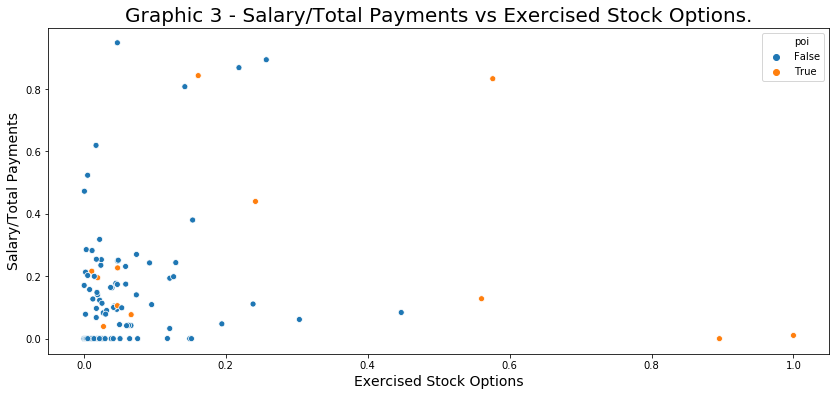

In [32]:
# Plotting a simple graphic to visualise.
plt.figure(figsize = [14, 6])
sns.scatterplot(y = 'ratio_salary_total_payments', x = df_eda.exercised_stock_options.astype(float)/df_eda.exercised_stock_options.astype(float).max(), hue = 'poi', data = df_eda)
plt.title('Graphic 3 - Salary/Total Payments vs Exercised Stock Options.', fontsize = 20)
plt.xlabel('Exercised Stock Options', fontsize = 14)
plt.ylabel('Salary/Total Payments', fontsize = 14);

* **total_income**

$$\text{total_income} = \text{total_payments} + \text{total_stock_value} \tag{2}$$

In [33]:
# Creating new feature.
df_eda['total_income'] = df_eda.total_payments.astype(float) + df_eda.total_stock_value.astype(float)

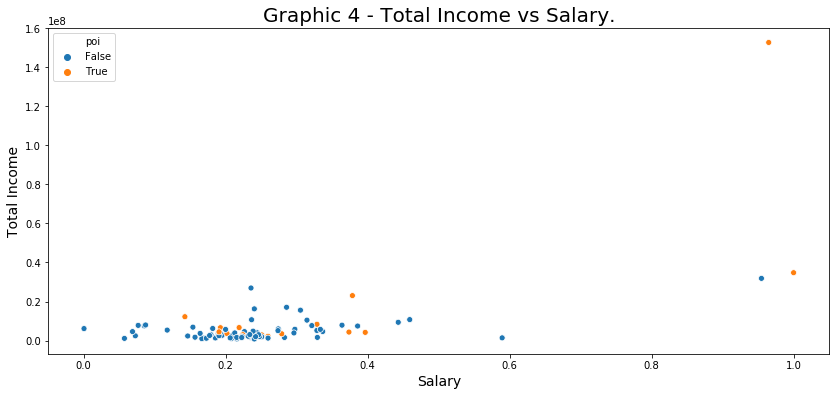

In [34]:
# Plotting a simple graphic to visualise.
plt.figure(figsize = [14, 6])
sns.scatterplot(y = 'total_income', x = df_eda.salary.astype(float)/df_eda.salary.astype(float).max(), hue = 'poi', data = df_eda)
plt.title('Graphic 4 - Total Income vs Salary.', fontsize = 20)
plt.xlabel('Salary', fontsize = 14)
plt.ylabel('Total Income', fontsize = 14);

* **ratio_stock_payments**

$$\text{ratio_stock_payments} = \frac{\text{total_stock_value}}{\text{total_payments}} \tag{3}$$

In [35]:
# 1. Adding the ratio_from_poi.
feature_engineering(df = df_eda,
                    ratio_name = 'ratio_stock_total_payments',
                    variable_numerator = df_eda.total_stock_value,
                    variable_denominator = df_eda.total_payments);

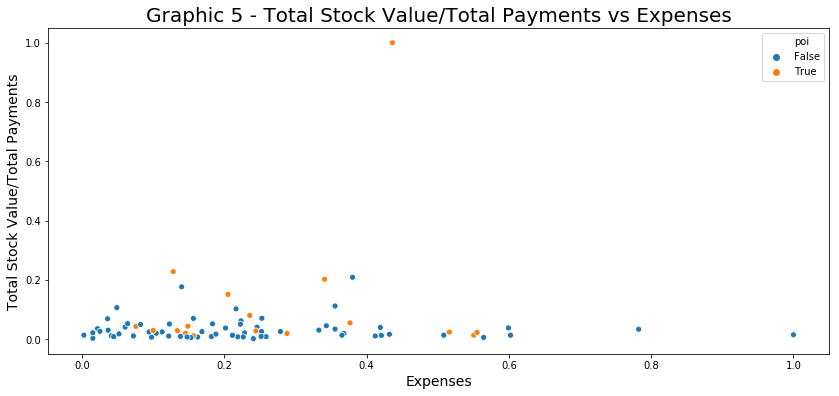

In [36]:
# Plotting a simple graphic to visualise.
plt.figure(figsize = [14, 6])
sns.scatterplot(y = df_eda.total_income/df_eda.total_income.max(), x = df_eda.expenses.astype(float)/df_eda.expenses.astype(float).max(), hue = 'poi', data = df_eda.query('ratio_stock_total_payments < 1000'))
plt.title('Graphic 5 - Total Stock Value/Total Payments vs Expenses', fontsize = 20)
plt.xlabel('Expenses', fontsize = 14)
plt.ylabel('Total Stock Value/Total Payments', fontsize = 14);

Unfortunately, I could not create any new features using data from email, mainly because these features has a lot of NaN values which could drive in Data Leakage.

Later in Feature Selection item, I will analyse each of these new features, if it is relevant to the model I will use it, if not I just need to drop out.

**Summary:** I have created 3 news features.

* ratio_salary_total_payments;
* total_income, and;
* ratio_stock_total_payments.

In [37]:
# Storing the list of engineered features.
engineered_features = ['ratio_salary_total_payments', 'total_income', 'ratio_stock_total_payments']

In [38]:
# Printing some features from df_clean. First 10 rows.
df_eda[['to_messages','from_messages','ratio_salary_total_payments', 'total_income','ratio_stock_total_payments']].head(10)

to_messages from_messages  ratio_salary_total_payments  \
ALLEN PHILLIP K           2902          2195                     0.045035   
BADUM JAMES P              NaN           NaN                     0.000000   
BANNANTINE JAMES M         566            29                     0.000521   
BAXTER JOHN C              NaN           NaN                     0.047406   
BAY FRANKLIN R             NaN           NaN                     0.289564   
BAZELIDES PHILIP J         NaN           NaN                     0.093960   
BECK SALLY W              7315          4343                     0.238714   
BELDEN TIMOTHY N          7991           484                     0.038897   
BELFER ROBERT              NaN           NaN                     0.000000   
BERBERIAN DAVID            NaN           NaN                     0.947950   

                    total_income  ratio_stock_total_payments  
ALLEN PHILLIP K        6213983.0                    0.385676  
BADUM JAMES P           440283.0                    1.412959  
BANNANTINE JAMES M     6159684.0                    5.723100  
BAXTER JOHN C         16257601.0                    1.885448  
BAY FRANKLIN R          890710.0                    0.076132  
BAZELIDES PHILIP J     2459777.0                    1.859754  
BECK SALLY W           1095095.0                    0.130050  
BELDEN TIMOTHY N       6612335.0                    0.201887  
BELFER ROBERT            58407.0                   -0.430176  
BERBERIAN DAVID        2722090.0                   10.914222

I have noticed the necessity to convert the `NaN` values to zero. The function `str_nan_to_0` will deal with the string one.

In [39]:
def str_nan_to_0(df, variable):
    """
    +--------------------------------------------------------------------------------------------------+
    |DESCRIPTION:                                                                                      |
    |                                                                                                  |
    |    This function converts the string NaN to zero.                                                |
    |                                                                                                  |
    +--------------------------------------------------------------------------------------------------+
    |INPUT:                                                                                            |
    |                                                                                                  |
    |    VARIABLE:                                                                                     |
    |                                                                                                  |
    |    df: Dataframe to perform the conversion.                                                      |
    |                                                                                                  |
    |    variable: The columns name to be converted.                                                   |
    |                                                                                                  |
    +--------------------------------------------------------------------------------------------------+
    |OUTPUT:                                                                                           |
    |                                                                                                  |
    |    VARIABLE:                                                                                     |
    |                                                                                                  |
    |    df: Dataframe with the converted columns.                                                     |
    |                                                                                                  |
    +--------------------------------------------------------------------------------------------------+
    """
    # Temporaly list
    temp = []

    # When the NaN is a string.
    # Loop to fix the NaN values.
    for index in df[variable]:
        if index == 'NaN':
            temp.append(0)
        else:
            temp.append(float(index))
            
    # Updatind the columns with NaN with list with 0.
    df[variable] = temp
    
    return df

Let's convert all the `NaN` to zero.

In [40]:
# Loop to convert all columns from df_eda.
for index in df_eda:
    # These two features do not need this conversion.
    if index in ['email_address']:
        continue
    else:
        # Convert String NaN to 0.
        str_nan_to_0(df = df_eda, variable = index);
        
        # Convert float NaN to 0.
        df_eda[index] = df_eda[index].fillna(0)

In [41]:
# Saving the dataset in dictionary type.
dict_eda = df_eda.to_dict(orient = 'index')

### 3.3. `featureFormat` and `targetFeatureSplit`

These two functions are given from the project template. I have coded a function to bundle them.

In [42]:
# Following the instructions.
my_dataset = dict_eda

# This is
def wrapper_featureformatsplit(my_dataset, features_list):
    """
    +--------------------------------------------------------------------------------------------------+
    |DESCRIPTION:                                                                                      |
    |                                                                                                  |
    |    This function runs two scripts: featureFormat and targetFeatureSplit.                         |
    |                                                                                                  |
    +--------------------------------------------------------------------------------------------------+
    |INPUT:                                                                                            |
    |                                                                                                  |
    |    VARIABLE:                                                                                     |
    |                                                                                                  |
    |    my_dataset: This is a dictionary.                                                             |
    |                                                                                                  |
    |    features_list: List of variable to be gathered from my_dataset.                               |
    |                                                                                                  |
    +--------------------------------------------------------------------------------------------------+
    |OUTPUT:                                                                                           |
    |                                                                                                  |
    |    VARIABLE:                                                                                     |
    |                                                                                                  |
    |    labels: This is the POI feature from my_dataset.                                              |
    |                                                                                                  |
    |    features: This is an array with the features_list values.                                     |
    |                                                                                                  |
    +--------------------------------------------------------------------------------------------------+
    """
    # Creating data ACCORDING to the features_list, which is input of targetFeatureSplit.
    data = featureFormat(my_dataset, features_list, sort_keys = True)

    # Using data to create labels and features.
    labels, features = targetFeatureSplit(data)
    
    # Returning the labels and features.
    return labels, features

In [43]:
# Using the defined wrapper_feat_form_split function.
labels, features = wrapper_featureformatsplit(my_dataset, original_feat)

The `labels` are the values `POI` and `non-POI`. This is what I want to predict.

In [44]:
# Printing the first labels.
labels[:5]

[0.0, 0.0, 0.0, 0.0, 0.0]

The feature is a numpy array where most of the variables from `dict_eda` are stored in a list.

$$features = [observation_1, \dots, observation_n]$$

Where:

$$observation_1 = [variable_1, variable_2, \dots, variable_{m}] $$

In [45]:
# Printing the first row of features.
features[0]

array([ 4.175000e+06,  2.869717e+06, -3.081055e+06,  0.000000e+00,
        1.729541e+06,  1.386800e+04,  2.195000e+03,  4.700000e+01,
        6.500000e+01,  0.000000e+00,  3.048050e+05,  1.520000e+02,
        1.260270e+05, -1.260270e+05,  2.019550e+05,  1.407000e+03,
        2.902000e+03,  4.484442e+06,  1.729541e+06])

### 3.3. Feature Scaling <a id='scaling'></a>

Due to the financial values varying from zero to a million dollar, these values could be dominant over the number of emails. For this reason, it is necessary to scale all the features. I will use the `MinMaxScaler` because this is the one used during the class.

In [46]:
# Function to scale.
def feat_scale(feat):
    """
    +--------------------------------------------------------------------------------------------------+
    |DESCRIPTION:                                                                                      |
    |                                                                                                  |
    |    Scale the matrix using the MinMaxScaler module from Scikit Learn.                             |
    |                                                                                                  |
    +--------------------------------------------------------------------------------------------------+
    |INPUT:                                                                                            |
    |                                                                                                  |
    |    VARIABLE:                                                                                     |
    |                                                                                                  |
    |    feat: Matrix/DataFrame to be scaled.                                                          |
    |                                                                                                  |
    +--------------------------------------------------------------------------------------------------+
    |OUTPUT:                                                                                           |
    |                                                                                                  |
    |    VARIABLE:                                                                                     |
    |                                                                                                  |
    |    feat: Scaled dataframe.                                                                       |
    |                                                                                                  |
    +--------------------------------------------------------------------------------------------------+
    """
    # Importing library.
    from sklearn.preprocessing import MinMaxScaler

    # Creating the classifier to scale.
    #scaler = MinMaxScaler()
    scaler = MinMaxScaler(feature_range=(-1, 1))

    
    # Fitting the classifier.
    scaler.fit(feat)

    # Transform the data. It means: Scale the data.
    feat = scaler.transform(feat)

    # Printing the scaled data.
    return feat

In [47]:
# Scaling the features dataframe.
features = feat_scale(features)

# Printing the first row of features.
features[0]

array([ 0.04375   , -0.0896021 , -0.75839933, -1.        , -0.89929419,
       -0.87875662, -0.69445991, -0.8219697 , -0.7865353 , -1.        ,
       -0.88152409, -0.99997066, -0.68553633, -0.80730865, -0.63652905,
       -0.49030973, -0.6168724 , -0.91339415, -0.92783384])

### 3.4. Feature Selection <a id='selection'></a>

Due to the several features available, I have decided to use the `SelectKBest` from Scikit Learn package to perform the Feature Selection.

The reasons to opt to feature selection:

* Reduce the overfitting, and;
* Reduce the computational processing time due to a simpler model, it also provides an easier model to interpret.

_Read more about it in this reference:_ [Feature Selection][lasso]

[lasso]: https://beta.vu.nl/nl/Images/werkstuk-fonti_tcm235-836234.pdf

The function below has calculated the "K Best Features".

In [48]:
# General purpose function.
def feat_selection(k , feat, lab, feat_list, f_classif = 'f_classif'):
    """
    Performs the SelectionKBest from a given feat and lab.
    
    Uses the f_classif to rank/score the features.
    """
    # Importing the modules SelectKBest and f_classif
    from sklearn.feature_selection import SelectKBest, f_classif

    # Creating the classifier.
    selector = SelectKBest(f_classif, k = k)

    # Fitting the data.
    selector.fit(feat, lab)

    # Printing the scores.
    selector.scores_ 
    
    # Create a DataFrame to ease the Comparison.
    comparison = pd.DataFrame(zip(feat_list[1:],selector.scores_,selector.pvalues_), columns = ['feature','scores','p_values'])
    
    # Sorting the DataFrame by scores.
    comparison.sort_values('scores', ascending = False, inplace = True)
    
    # Multiple values to return.
    return comparison

I have used, for this example, all features available from `data_dict`.

The `wrapper_featureformatsplit` function has created labels and features.

In [49]:
# Creating the label vector and features dataframe.
lab_original, feat_original = wrapper_featureformatsplit(my_dataset = my_dataset, features_list = original_feat)

##### Original Features

In [50]:
# Original features.
original_feat

['poi',
 'bonus',
 'deferral_payments',
 'deferred_income',
 'director_fees',
 'exercised_stock_options',
 'expenses',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'loan_advances',
 'long_term_incentive',
 'other',
 'restricted_stock',
 'restricted_stock_deferred',
 'salary',
 'shared_receipt_with_poi',
 'to_messages',
 'total_payments',
 'total_stock_value']

In [51]:
# Using the function feat_selection() and show the first 5 best scored variables.
feat_sel_results = feat_selection(k = 'all', feat = feat_original, lab = lab_original, feat_list = original_feat)

# Printing.
feat_sel_results.query('p_values < 0.05')

feature     scores  p_values
4   exercised_stock_options  24.815080  0.000002
18        total_stock_value  24.182899  0.000002
0                     bonus  20.792252  0.000011
14                   salary  18.289684  0.000035
2           deferred_income  11.458477  0.000922
10      long_term_incentive   9.922186  0.001994
12         restricted_stock   9.212811  0.002863
17           total_payments   8.772778  0.003589
15  shared_receipt_with_poi   8.589421  0.003946
9             loan_advances   7.184056  0.008232
5                  expenses   6.094173  0.014758
7   from_poi_to_this_person   5.243450  0.023514
11                    other   4.187478  0.042582

I have configured the `SelectKBest` to use the `f_classif`, which means I want to calculate the ANOVA (Analysis of Variance) to rank the features.

$$\text{F value} = \frac{\text{Mean Square Between}}{\text{Mean Squared Error}}$$

Where: `F values` is the same of `scores`.

The Hypothesis test behind the scenes is:

>Is the variance between the means of two populations significantly different?

<img src="01-img/f-table.jpg">

<center><em>Figure 1 - F-distribution example.</em></center>

[Source][statisticshowto]

[statisticshowto]: https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/f-statistic-value-test/

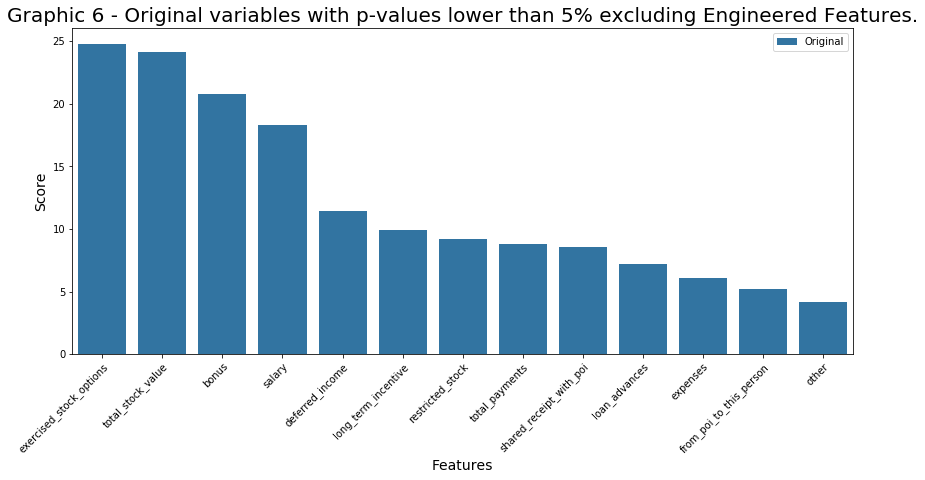

In [52]:
# Adding the hue to be comparable to the next graphic.
feat_sel_results['hue'] = 'Original'

# Ploting the graphic.
plt.figure(figsize = [14, 6])
ax = sns.barplot(x = feat_sel_results.query('p_values < 0.05').feature,
                 y = feat_sel_results.query('p_values < 0.05').scores,
                 hue = feat_sel_results.hue);
plt.title('Graphic 6 - Original variables with p-values lower than 5% excluding Engineered Features.', fontsize = 20)
plt.ylabel('Score', fontsize = 14)
plt.xlabel('Features', fontsize = 14)
plt.legend();
plt.setp(ax.get_xticklabels(), rotation=45,  # 45 degrees labels on X axis
         ha="right", rotation_mode="anchor")
plt.show()

Assuming the $\alpha$ equal to 0.05, there are 13 features with p-values lower than $\alpha$, which means when adding these features its somehow changes the output (there is statistical significance).

I have adopted a strategy to remove some features with greater potential to insert Data Leakage the model.

* Features with `nan` proportion lower than 0.4, and;
* Features with `p_values` lower than $\alpha$ (0.05).

In [53]:
# Copying.
original_feature = feat_sel_results.copy()

# Defining new index names.
original_feature.index = original_feature.feature.tolist()

# Dropping the features columns.
original_feature.drop(columns = ['feature', 'hue'], inplace = True)

# Merging and filtering
original_feature = original_feature.join(nan_proportion[1:]).query('nan < .40').query('p_values < 0.05')

original_feature

scores  p_values   nan
exercised_stock_options  24.815080  0.000002  0.30
total_stock_value        24.182899  0.000002  0.14
salary                   18.289684  0.000035  0.35
restricted_stock          9.212811  0.002863  0.25
total_payments            8.772778  0.003589  0.14
expenses                  6.094173  0.014758  0.35
other                     4.187478  0.042582  0.36

The set of features selected using only original features are seven (excluding the `poi`):

* poi;
* exercised_stock_options;
* total_stock_value;
* salary;
* restricted_stock;
* total_payments;
* expenses, and;
* other.

##### Original plus Engineered Features

Let's use the `SelectedKBest` but now using all features (original and the engineered features).

In [54]:
# Adding to the original_feat list the engineered features.
complete_feat = original_feat + engineered_features

# Printing.
complete_feat

['poi',
 'bonus',
 'deferral_payments',
 'deferred_income',
 'director_fees',
 'exercised_stock_options',
 'expenses',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'loan_advances',
 'long_term_incentive',
 'other',
 'restricted_stock',
 'restricted_stock_deferred',
 'salary',
 'shared_receipt_with_poi',
 'to_messages',
 'total_payments',
 'total_stock_value',
 'ratio_salary_total_payments',
 'total_income',
 'ratio_stock_total_payments']

Creating the labels and features using the wrapper function.

In [55]:
# Creating the label vector and features dataframe.
lab_complete, feat_complete = wrapper_featureformatsplit(my_dataset = my_dataset, features_list = complete_feat)

Calculating the `scores`.

In [56]:
# Using the function feat_selection() and show the first 5 best scored variables.
feat_sel_results_complete = feat_selection(k = 10, feat = feat_complete, lab = lab_complete, feat_list = complete_feat)

# Printing.
feat_sel_results_complete.query('p_values < 0.05')

feature     scores  p_values
4   exercised_stock_options  24.815080  0.000002
18        total_stock_value  24.182899  0.000002
0                     bonus  20.792252  0.000011
14                   salary  18.289684  0.000035
20             total_income  17.808791  0.000044
2           deferred_income  11.458477  0.000922
10      long_term_incentive   9.922186  0.001994
12         restricted_stock   9.212811  0.002863
17           total_payments   8.772778  0.003589
15  shared_receipt_with_poi   8.589421  0.003946
9             loan_advances   7.184056  0.008232
5                  expenses   6.094173  0.014758
7   from_poi_to_this_person   5.243450  0.023514
11                    other   4.187478  0.042582

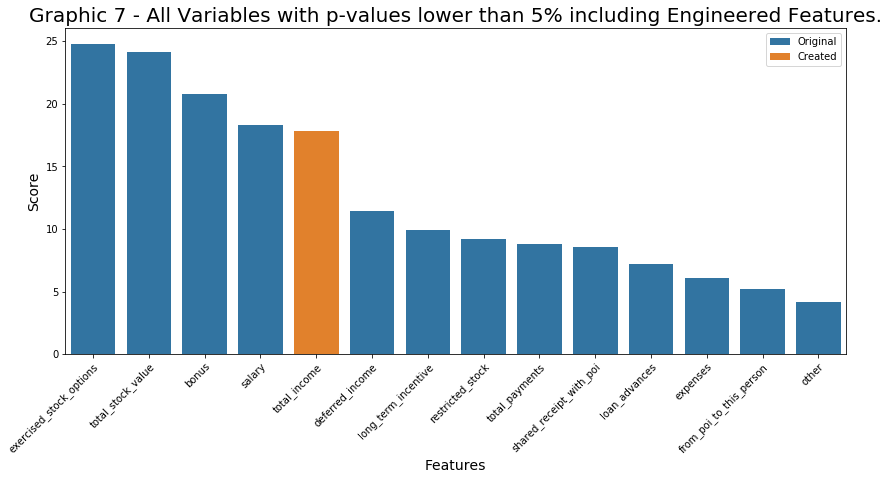

In [57]:
# Adding a new columns to use as hue in the graphic.

# Temporaly variable only to store if this is a feature engineered or not.
my_hue = []

# Loop to check it.
for feat_name in feat_sel_results_complete.feature:
    if feat_name in engineered_features:
        my_hue.append('Created')
    else:
        my_hue.append('Original')

feat_sel_results_complete['hue'] = my_hue
        
# Ploting the graphic.
plt.figure(figsize = [14, 6])
ax = sns.barplot(x = feat_sel_results_complete.query('p_values < 0.05').feature,
                 y = feat_sel_results_complete.query('p_values < 0.05').scores,
                 hue = feat_sel_results_complete.hue, dodge = False);
plt.title('Graphic 7 - All Variables with p-values lower than 5% including Engineered Features.', fontsize = 20)
plt.ylabel('Score', fontsize = 14)
plt.xlabel('Features', fontsize = 14)
plt.legend();
plt.setp(ax.get_xticklabels(), rotation=45,  # 45 degrees labels on X axis
         ha="right", rotation_mode="anchor")
plt.show()

Assuming the $\alpha$ equal to 0.05, there are 14 features with p-values lower than $\alpha$. One engineered features has aggregated.

In [58]:
# Initializing a dictionary to store the NaN proportion.
nan_proportion_complete = dict()

# Loop to create the proportion of NaN per variable.
for index in df_eda.columns.tolist():
    nan_proportion_complete[index] = round(sum(df_eda[index] == 0)/float(len(df_eda[index])), 2)
    
# Converting in pandas DataFrame.
nan_proportion_complete = pd.DataFrame.from_dict(nan_proportion_complete, orient='index', columns = ['nan'])

# Copying.
complete_feature = feat_sel_results_complete.copy()

# Defining new index names.
complete_feature.index = complete_feature.feature.tolist()

# Dropping the features columns.
complete_feature.drop(columns = ['feature','hue'], inplace = True)

# Merging and filtering
complete_feature = complete_feature.join(nan_proportion_complete).query('p_values < 0.05').query('nan < 0.40')

complete_feature

scores  p_values   nan
exercised_stock_options  24.815080  0.000002  0.29
total_stock_value        24.182899  0.000002  0.13
salary                   18.289684  0.000035  0.34
total_income             17.808791  0.000044  0.25
restricted_stock          9.212811  0.002863  0.24
total_payments            8.772778  0.003589  0.14
expenses                  6.094173  0.014758  0.34
other                     4.187478  0.042582  0.36

The set of features selected using only original features are eight (excluding the `poi`):

* poi;
* exercised_stock_options;
* total_stock_value;
* salary;
* total_income (engineered features);
* restricted_stock;
* total_payments;
* expenses, and;
* other.


I have created two lists of features:

* `features_significant_original`;
    * Only original features with significance lower than 0.05 and `nan` lower than 0.40;
* `features_significant_complete`;
    * Original features plus engineered features with significance lower than 0.05 and `nan` lower than 0.40.

In [59]:
# Saving the lists of features.
features_significant_original = ['poi'] + original_feature.index.tolist()
features_significant_complete = ['poi'] + complete_feature.index.tolist()

Let's plot the correlation map for the `features_significant_original`.

In [60]:
# Creating a function to calculate the correlation between variables.
def calc_correlation(df, feat_list):
    """
    Calculates the correlation between variables from df DataFrame which is
    in the feat_list.
    """
    # Temporaly variable. List to store the columns values.
    temp = []

    # Loop to subset the dataframe.
    for index in feat_list:
        temp.append(df[index])

    # Correlation Calculation.
    return pd.DataFrame(np.corrcoef(temp), columns = feat_list, index = feat_list)

In [61]:
# Creating a function to plot a heatmap.
def heatmap(df_corr, title):
    """
    Based on the df_corr (it is a list) creates a "heatmap" of correlations.
    """
    plt.figure(figsize = [8,6])                  # Graph/Figure size
    ax = sns.heatmap(df_corr, linewidth=0.5)     # Heatmap
    ax.set_xticklabels(df_corr.index)            # X ticks labels
    ax.set_yticklabels(df_corr.columns)          # Y ticks labels
    plt.setp(ax.get_xticklabels(), rotation=45,  # 45 degrees labels on X axis
             ha="right", rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=0,   # 0 degree labels on Y axis
             ha="right", rotation_mode="anchor")
    plt.title(title,
              fontsize = 20);
    plt.show()

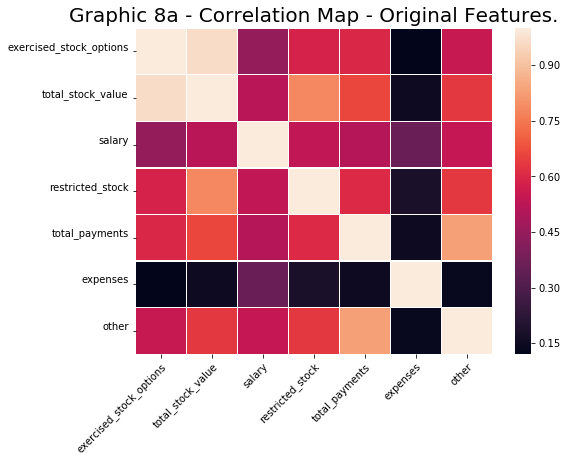

In [62]:
# Priting the heatmap.
heatmap(calc_correlation(df_eda, feat_list = features_significant_original[1:]),
        title = "Graphic 8a - Correlation Map - Original Features.")

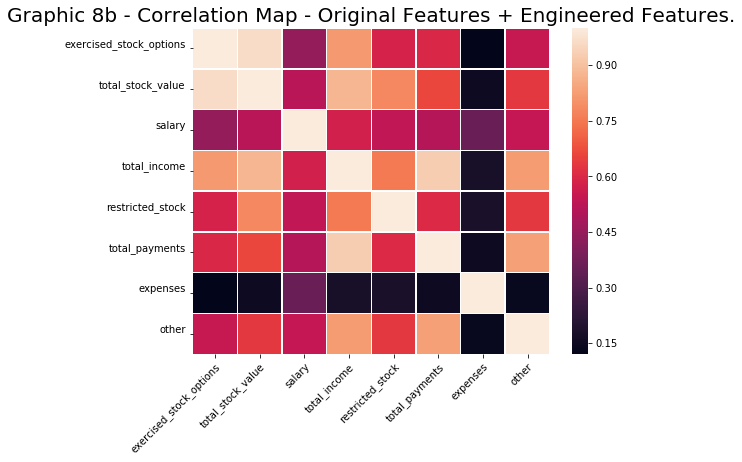

In [63]:
# Priting the heatmap.
heatmap(calc_correlation(df_eda, feat_list = features_significant_complete[1:]),
        title = "Graphic 8b - Correlation Map - Original Features + Engineered Features.")

As you can see, there are variables with high correlation such as:

* `exercised_stock_options` and `total_stock_value`, and;
* `expenses`which do not have relationship with any variable.

#### 3.4.1. Evaluating Sets of Features <a id='fatures_evaluation'></a>

Let's evaluate the lists of features `features_significant_original` and `features_significant_complete` using standards configuration of several classifiers.

The reason to do it is to make a sensible analysis of features selected to the final model (`features_list`).

In [64]:
def select_fit_evaluate(classifier, features_list, my_dataset = my_dataset):
    """
    This function calculates the accuracy, recall, and precision given the training, testing
    dataset, and classifier.
    
    I have improved this function adding the SSS.
    """
    
    # Creating the label vector and features dataframe.
    lab, feat = wrapper_featureformatsplit(my_dataset = my_dataset, features_list = features_list)
    
    # Initializing variables.
    acc = []
    rec_poi = []
    rec_non_poi = []
    pre_poi = []
    pre_non_poi = []
    
    # Converting to Arrays.
    X = np.array(feat)
    y = np.array(lab)
    
    # Creating the object.
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
    sss.get_n_splits(X, y)
    
    # Loop to run n_split times. Creating n_split differents training and test dataset.
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        # Unzipping the list from the create_traintest funciton.
        feat_train, feat_test, lab_train, lab_test = X_train, X_test, y_train, y_test
    
        # List of Classifier and parameters.
        list_class = {'ada':('ada', AdaBoostClassifier(n_estimators=100)),
                      'svc':('svc', SVC(gamma='auto')),
                      'tree':('tree', tree.DecisionTreeClassifier()),
                      'gauss':('gauss', GaussianNB()),
                      'knn':('knn', KNeighborsClassifier(n_neighbors=5)),
                      'random':('rand', RandomForestClassifier(n_estimators = 100))}

        # Creating the Pipeline.
        pipeline_ = Pipeline([list_class[classifier]])

        # Fitting.
        pipeline_.fit(feat_train,lab_train)

        # Predicting.
        pred_t = pipeline_.predict(np.array(feat_test))

        # Calculating the accuracy.
        acc.append(accuracy_score(lab_test, pred_t))

        # Calculating the recall. It is an array of (recall non-POI, recall POI)
        recall = recall_score(y_true = lab_test, y_pred = pred_t, average = None)
        rec_non_poi.append(recall[0])
        rec_poi.append(recall[1])
        
        # Calculating the precision. It is an array of (precision non-POI, precision POI)
        precision = precision_score(y_true = lab_test, y_pred = pred_t, average = None)
        pre_non_poi.append(precision[0])
        pre_poi.append(precision[1])
        
    
    # Return the accuracy.
    return np.mean(acc), [np.mean(rec_non_poi), np.mean(rec_poi)], [np.mean(pre_non_poi), np.mean(pre_poi)]

So far I have created 2 lists of features.

* `features_significant_original`;
* `features_significant_complete`.

However, I have used the opportunity to evaluate more two set of features:

* `original_feat`: All 20 features from the original source;
* `complete_feat`: All 20 features from the original source plus 3 Engineered Features;

In [65]:
# Considering the 'POI'.
print "features_significant_original", len(features_significant_original)
print "features_significant_complete", len(features_significant_complete)
print "original_feat", len(original_feat)
print "complete_feat", len(complete_feat)

features_significant_original 8
features_significant_complete 9
original_feat 20
complete_feat 23


In [66]:
# All list I have created so far.
all_list = [original_feat, complete_feat, features_significant_original, features_significant_complete]

The follow function will create a table of comparison of a given list of features.

In [67]:
# Creates a table of comparison.
def comparison_metrics(classifier, list_of_list):
    """
    Creates a dataframe with the values of accuracy, recall, and precision for all
    set of features in list_of_list.
    """
    import warnings
    warnings.filterwarnings("ignore")
    
    # Compute the time consuming.
    import time
    
    # Tracking the time.
    t_start = time.time()
    
    # Temporaly variables to store the values of accuracy, recall and precision.
    acc = [] # Accuracy
    recall = [] # recall from poi and non-poi
    precision = [] # precision from poi and non-poi

    # Loop to calculate for each list of features the accuracy, precision and recall.
    for index in list_of_list:
        # Unloading the values calculated by select_fit_evaluate function. 
        i_acc,\
        i_recall,\
        i_precision = select_fit_evaluate(classifier = classifier, features_list = index, my_dataset = my_dataset)
        
        # Appending the values in the list.
        acc.append(i_acc)
        recall.append(i_recall)
        precision.append(i_precision)

    # Converting to DataFrame.
    acc = pd.DataFrame(acc, columns = ['accuracy'])
    recall = pd.DataFrame(recall, columns = ['recall_non_poi','recal_poi'])
    precision = pd.DataFrame(precision, columns = ['precision_non_poi','precision_poi'])

    # Merging.
    comparison = acc.join(recall).join(precision)

    # Renaming the rows.
    comparison.index = ['original_feat','complete_feat','features_significant_original','features_significant_complete']

    # Tracking the time
    t_end = time.time()
    
    print "Duration:", round((t_end - t_start)/60, 4), "minutes"
    
    # Printing the results.
    return comparison

Let's compare each set of features using different classifiers.

### Task 4 - Try a varity of classifiers <a id='task4'></a>

>**Try a varity of classifiers**

I have used 4 different set of features for each classifier.

Bear in mind, the comparison takes into account the recall and precision for both labels (0 and 1). 

In [68]:
np.random.seed(42)

# Naïve Bayes.
comparison_metrics(classifier = 'gauss', list_of_list = all_list)

Duration: 0.0037 minutes


accuracy  recall_non_poi  recal_poi  \
original_feat                  0.661111        0.693548       0.46   
complete_feat                  0.680556        0.725806       0.40   
features_significant_original  0.841667        0.945161       0.20   
features_significant_complete  0.847222        0.948387       0.22   

                               precision_non_poi  precision_poi  
original_feat                           0.884213       0.268912  
complete_feat                           0.879274       0.341293  
features_significant_original           0.879778       0.410000  
features_significant_complete           0.882855       0.431667

In [69]:
# Random Forest.
comparison_metrics(classifier = 'random', list_of_list = all_list)

Duration: 0.2109 minutes


accuracy  recall_non_poi  recal_poi  \
original_feat                  0.855556        0.977419       0.10   
complete_feat                  0.858333        0.980645       0.10   
features_significant_original  0.850000        0.967742       0.12   
features_significant_complete  0.863889        0.967742       0.22   

                               precision_non_poi  precision_poi  
original_feat                           0.870916       0.308333  
complete_feat                           0.871294       0.316667  
features_significant_original           0.872627       0.265000  
features_significant_complete           0.885436       0.515000

In [70]:
# AdaBoost.
comparison_metrics(classifier = 'ada', list_of_list = all_list)

Duration: 0.1559 minutes


accuracy  recall_non_poi  recal_poi  \
original_feat                  0.833333        0.932258       0.22   
complete_feat                  0.841667        0.938710       0.24   
features_significant_original  0.836111        0.925806       0.28   
features_significant_complete  0.850000        0.945161       0.26   

                               precision_non_poi  precision_poi  
original_feat                           0.881067       0.381667  
complete_feat                           0.884735       0.390000  
features_significant_original           0.889118       0.386905  
features_significant_complete           0.887541       0.533333

In [71]:
# Decision Tree.
comparison_metrics(classifier = 'tree', list_of_list = all_list)

Duration: 0.0029 minutes


accuracy  recall_non_poi  recal_poi  \
original_feat                  0.797222        0.896774       0.18   
complete_feat                  0.802778        0.893548       0.24   
features_significant_original  0.786111        0.867742       0.28   
features_significant_complete  0.786111        0.874194       0.24   

                               precision_non_poi  precision_poi  
original_feat                           0.871459       0.272619  
complete_feat                           0.879674       0.276905  
features_significant_original           0.882926       0.245198  
features_significant_complete           0.877001       0.263452

In [72]:
# K Nearest Neighbor.
comparison_metrics(classifier = 'knn', list_of_list = all_list)

Duration: 0.0034 minutes


accuracy  recall_non_poi  recal_poi  \
original_feat                  0.863889        0.990323       0.08   
complete_feat                  0.877778        0.996774       0.14   
features_significant_original  0.866667        0.993548       0.08   
features_significant_complete  0.883333        0.996774       0.18   

                               precision_non_poi  precision_poi  
original_feat                           0.869883           0.30  
complete_feat                           0.877997           0.65  
features_significant_original           0.870219           0.35  
features_significant_complete           0.883002           0.80

In [73]:
# Support Vector Machine.
comparison_metrics(classifier = 'svc', list_of_list = all_list)

Duration: 0.0032 minutes


accuracy  recall_non_poi  recal_poi  \
original_feat                  0.861111             1.0        0.0   
complete_feat                  0.861111             1.0        0.0   
features_significant_original  0.861111             1.0        0.0   
features_significant_complete  0.861111             1.0        0.0   

                               precision_non_poi  precision_poi  
original_feat                           0.861111            0.0  
complete_feat                           0.861111            0.0  
features_significant_original           0.861111            0.0  
features_significant_complete           0.861111            0.0

Comparing the results of `features_significant_original` and `features_significant_complete`.

<strong><center>Table 3 - Performance Comparison between Original Features and Original Features plus Engineered Features.</center></strong>

|Classifier        |Set of features              |Accuracy|Recall POI|Precision POI|
|:-:               |:-:                          |:-:     |:-:       |:-:          |
|SVM               |features_significant_original|0.861111|0         |0            |
|SVM               |features_significant_complete|0.861111|0         |0            |
|Naïve Bayes       |features_significant_original|0.841667|0.20      |0.410000     |
|Naïve Bayes       |features_significant_complete|0.847222|0.22      |0.431667     |
|AdaBoost          |features_significant_original|0.836111|0.28      |0.386905     |
|AdaBoost          |features_significant_complete|0.850000|0.26      |0.533333     |
|K-Nearest Neighbor|features_significant_original|0.866667|0.08      |0.35         |
|K-Nearest Neighbor|features_significant_complete|0.883333|0.18      |0.80         |
|Decision Trees    |features_significant_original|0.786111|0.28      |0.245198     |
|Decision Trees    |features_significant_complete|0.786111|0.24      |0.263452     |
|Random Forest     |features_significant_original|0.850000|0.12      |0.265000     |
|Random Forest     |features_significant_complete|0.863889|0.22      |0.515000     |

There is evidence that `features_significant_complete` has yielded better results than `features_significant_original`, which means that the engineered feature (`total_income`) has improved the overall results.

### Task 1 - Feature List <a id='task1'></a>

>**Select what features you'll use.**

Due to the slightly better results using the `features_significant_complete`, I have decided to select it as `feature_list`.

In [74]:
# Definition of feature_list
feature_list = features_significant_complete

# Printing.
feature_list

['poi',
 'exercised_stock_options',
 'total_stock_value',
 'salary',
 'total_income',
 'restricted_stock',
 'total_payments',
 'expenses',
 'other']

### 3.5. Dimension Reduction <a id='pca'></a>

Due to the few features of this model (8 in `features_significant_original` and 9 in `feature_list`), I will not use the PCA because I do not see any advantages to reduce the number of features, the trade-off between computational performance and information-loss it is in favour to keep the features as is.

***

# 4. Predicting <a id='predicting'></a>

So far I have used non-tuned classifiers, the next step of this project is to adjust the parameters to find a better solution. Remember, the main objective of this project is to create a model capable to classify an employee (in POI or non-POI) based on past experiences (database).

##### Cross-validation

For this step, I have used the [StratifiedShuffleSplit][sk_learn_sss] cross-validation model to aid in the process of model selection. It is necessary to evaluate the model using an independent dataset (the so-called test dataset) to avoid the overfitting the model. The `StratifiedShuffleSplit` function runs several times (`n_split`) the same model using the same parameters but varying the datasets of training and test (shuffling the observations). All this preserving the proportion of each label.

[sk_learn_sss]: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

## 4.1. Tuning Parameters <a id='tuning'></a>

In this chapter I have performed the parameters' tuning from several classifiers, due to the so many different parameters combination and the difficult to create a function to automize it, I have done it manually.

The general setup for each calibration:

* Training and Test dataset based on `feature_list`;
* The metric to evaluate (scoring) each simulation elect was the 'f1';
* Cross-validation using `StratifiedShuffleSplit` and `n_split` equal to 20, and;
* Random State = 42.

Let's create a dedicated dataset for tuning.

In [75]:
# Creating Datasets to be used in tuning.
lab_tuning, feat_tuning = wrapper_featureformatsplit(my_dataset = my_dataset, features_list = feature_list)

# Scaling.
feat_tuning = feat_scale(feat_tuning)

To avoid repetition in the report, I have created a function to bundle some code lines. The output of this function is the classifier, the reason to return a classifier is due to the flexibility provided using it. I could use all methods of `GridSearchCV`, for instance:

* `.best_estimator_`;
* `.cv_results_`, and etc.

In [76]:
# Function to encapsulate some code lines.
def tuning(parameters, classifier, feat = feat_tuning, lab = lab_tuning, scoring = 'f1', n_splits = 20, random_state = None):
    """
    This function ensemble the GridSearchCV and Pipeline to run several types of classifiers
    and several values of parameters.
    """
    
    import warnings
    warnings.filterwarnings("ignore")
    
    
    # Dictionary of Classifiers and Constructors.
    list_class = {'ada':('ada', AdaBoostClassifier()),
                  'svc':('svc', SVC()),
                  'tree':('tree', tree.DecisionTreeClassifier()),
                  'gauss':('gauss', GaussianNB()),
                  'knn':('knn', KNeighborsClassifier()),
                  'rand':('rand', RandomForestClassifier())}
    
    # Creating the Pipeline.
    pipeline = Pipeline([list_class[classifier]])

    # Creating the GridSearch Object.
    clf = GridSearchCV(estimator = pipeline,                         # Pipeline
                       param_grid = parameters,                      # Parameters to be tested.
                       cv = StratifiedShuffleSplit(n_splits = n_splits,    # Number of splits.
                                                   test_size = 0.25, # Test Dataset size
                                                   random_state = random_state), # Set the random seed.
                            scoring = scoring)                       # Metric to evaluate.
    
    # Fitting.
    clf.fit(feat, lab)
    
    # Printing recall. It is the MEAN of 20 instances/n_splits.
    print "F1:", round(100 * clf.cv_results_['mean_test_score'].max(), 2), "%"
    
    # Creating a vector to select the best value.
    select_best = clf.cv_results_['mean_test_score'] == clf.cv_results_['mean_test_score'].max()
    
    print "F1 Standard Deviation:", round( 100 * clf.cv_results_['std_test_score'][select_best][0], 2), "%"
    
    # Return the classifier.
    return clf

Sadly, I have not found an easy way to implement a heuristic to guide me to find good values of parameters (I got traumatized coding a Genetic Algorithm, for this reason, I have performed it manually). Thus, I adopted these concepts to drive through the optimized parameters.

- Best first search;
- Divide-and-conquer.

#### Best First Search

Generally, classifiers have a lot of parameters. I have defined the following strategy:

* Start by the Scalar parameters;
    * Integer;
    * Floats;
* Categorical parameters.

I will take the most promising node for each tree level, it means, I will find the optimized value for parameter_1 and keep all the other parameters constant then I move to the next parameter and repeat the same concept.

[Source][best_first_search]

[best_first_search]: https://en.wikipedia.org/wiki/Best-first_search

#### Divide-and-conquer

As a first step, I take 2 reasonable values (using intuition or the default values from the Scikit Learn) for each level of the tree (in this case the same of a parameter) and calculate the mean, which I will use as a parameter candidate.

$$\text{paramater}_1 = [value_1, mean, value_2]$$

After calculating the evaluation metric using these three values, it is possible to determine in which of the two parts the optimized value is much closed. Suppose the `value_1` is the one with a better evaluation metric.

$$\text{paramater}_1 = [value_1, \frac{value_1 + mean}{2},mean]$$

So the cycle restarts.

Have in mind, there are other situations, and this is just a brief explanation of how I have conducted the calibration.

[Source][divide_and_conquer]

[divide_and_conquer]: https://en.wikipedia.org/wiki/Divide-and-conquer_algorithm

#### Caveat

There are several caveats in this approach one of them is I could fall in a local maximum (mostly because I do not use backtracking).

### 4.1.1. Support Vector Machine (SVM) Tuning

Optimized parameters:

* kernel: rbf;
* C: 1000;
* degree: 1;
* gamma: 4.3, and;
* F1 (mean): 18.72%.

In [77]:
# Defining possible parameters.
parameters = {'svc__kernel':['rbf','linear'],
              'svc__C':[1000.,1010, 990],
              'svc__degree':[1,2],
              'svc__gamma':[4.2, 4.3, 4.1]}

# Creating the classifier using the function tuning.
clf = tuning(parameters, 'svc', feat_tuning, lab_tuning, 'f1', random_state = 42)

# Printing the optimized estimator.
clf.best_estimator_

F1: 18.72 %
F1 Standard Deviation: 17.59 %


Pipeline(memory=None,
     steps=[('svc', SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma=4.3, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Creating a classifier with optimized parameters.

In [78]:
# Creating a classifier with the optimized parameters.
clf_svm = SVC(kernel = 'rbf', C = 1000, degree = 1, gamma = 4.3)

### 4.1.2. Naïve Bayes Tuning

The Naïve Bayes does not have any parameter to calibrate.

* F1 (mean): 24.00%.

In [79]:
# Defining parameters.
parameters = {}

# Creating classifier and training. Bear in mind, the random state.
clf = tuning(parameters, 'gauss', feat_tuning, lab_tuning, 'f1', random_state = 42)

# Printing optimized estimators.
clf.best_estimator_

F1: 24.0 %
F1 Standard Deviation: 17.12 %


Pipeline(memory=None, steps=[('gauss', GaussianNB(priors=None))])

Creating a classifier with optimized parameters.

In [80]:
# Creating a classifier with the optimized parameters.
clf_gauss = GaussianNB()

### 4.1.3. AdaBoost Tuning

Optimized parameters:

* n_estimators: 67;
* learning_rate: 1, and;
* F1 (mean): 25.35%.

In [81]:
# Defining parameters.
parameters = {'ada__n_estimators':[68, 67, 66],
              'ada__learning_rate':[0.9, 1.0, 1.1]}

# Creating classifier and training. Bear in mind, the random state.
clf  = tuning(parameters, 'ada', feat_tuning, lab_tuning, 'f1', random_state = 42)

# Printing optimized estimators.
clf.best_estimator_

F1: 25.35 %
F1 Standard Deviation: 20.91 %


Pipeline(memory=None,
     steps=[('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=67, random_state=None))])

Creating a classifier with optimized parameters.

In [82]:
# Creating a classifier with the optimized parameters.
clf_ada = AdaBoostClassifier(learning_rate = 1.0, n_estimators = 67)

### 4.1.4. K-Nearest Neighbors Tuning

Optimized parameters:

* n_neighbors: 1;
* algorithm: auto;
* leaf_size: 1;
* p: 2, and;
* F1 (mean): 24.43%.

In [83]:
# Defining parameters.
parameters = {'knn__n_neighbors': [1, 2,3],
              'knn__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
              'knn__leaf_size':[1, 2,3],
              'knn__p':[1, 2,3]}

# Creating classifier and training. Bear in mind, the random state.
clf  = tuning(parameters, 'knn', feat_tuning, lab_tuning, 'f1', random_state = 42)

# Printing optimized estimators.
clf.best_estimator_

F1: 24.43 %
F1 Standard Deviation: 21.79 %


Pipeline(memory=None,
     steps=[('knn', KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])

Creating a classifier with optimized parameters.

In [84]:
# Creating a classifier with the optimized parameters.
clf_knn = KNeighborsClassifier(n_neighbors = 1, algorithm = 'auto', leaf_size = 1, p = 2)

### 4.1.5. Decision Trees Tuning

Optimized parameters:

* class_weight: 'balanced';
* criterion: 'entropy';
* max_leaf_nodes: 3;
* min_samples_leaf: 1;
* min_samples_split: 2;
* splitter: 'best';
* max_depth: 5, and;
* F1 (mean): 49.71%.

In [85]:
# Defining parameters.
parameters = {'tree__class_weight':[None,'balanced'],
              'tree__criterion': ['gini', 'entropy'],
              'tree__max_depth': [5, 6 , 4],
              'tree__splitter':['best', 'random'],
              'tree__max_leaf_nodes':[None, 2, 3, 4],
              'tree__min_samples_leaf':[1, 2, 3],
              'tree__min_samples_split': [2, 3, 4]}

# Creating classifier and training. Bear in mind, the random state.
clf  = tuning(parameters, 'tree', feat_tuning, lab_tuning, 'f1', random_state = 42)

# Printing optimized estimators.
clf.best_estimator_

F1: 49.71 %
F1 Standard Deviation: 11.58 %


Pipeline(memory=None,
     steps=[('tree', DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=4, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])

Creating a classifier with optimized parameters.

In [86]:
# Creating a classifier with the optimized parameters.
clf_tree = tree.DecisionTreeClassifier(splitter = 'best',
                                       criterion = 'gini',
                                       class_weight = 'balanced',
                                       min_samples_leaf = 1,
                                       min_samples_split = 2,
                                       max_depth = 5,
                                       max_leaf_nodes = 4)

### 4.1.6. Random Forest Tuning

Optimized parameters:

* class_weight: 'balanced';
* criterion: 'gini';
* max_leaf_nodes: 2;
* min_samples_leaf: 2;
* min_samples_split: 3;
* max_depth: 5, and;
* Recall (mean): 46.58%.

In [87]:
# Ensure the reproducibility.
np.random.seed(42)

# Defining parameters.
parameters = {'rand__class_weight':['balanced'],
              'rand__criterion': ['gini', 'entropy'],
              'rand__n_estimators':[5, 4, 3],
              'rand__max_depth': [5, 3, 4],
              'rand__max_leaf_nodes':[3, 2],
              'rand__min_samples_leaf':[3, 2, 1],
              'rand__min_samples_split':[3, 2]}

# Creating classifier and training. Bear in mind, the random state.
clf  = tuning(parameters, 'rand', feat_tuning, lab_tuning, 'f1')

# Printing optimized estimators.
clf.best_estimator_

F1: 46.58 %
F1 Standard Deviation: 12.46 %


Pipeline(memory=None,
     steps=[('rand', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=3, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

Creating a classifier with optimized parameters.

In [88]:
# Creating a classifier with the optimized parameters.
clf_rand = RandomForestClassifier(n_estimators = 5,
                                  class_weight = 'balanced',
                                  criterion = 'gini', 
                                  max_depth = 5, 
                                  max_leaf_nodes = 3, 
                                  min_samples_leaf = 3, 
                                  min_samples_split = 3)

### 4.1.7. Optimized Parameters Output Comparison

Table 4 compares the F1 (mean of 20 stratified shuffle split F1 metric) from the process of tuning.

<strong><center>Table 4 - F1 Performance of Tuning Process.</center></strong>

|Classifier|F1 \[%\]|Standard Deviation \[%\]|
|:-:|:-:|:-:|
|SVM|18.72|17.59|
|Naïve Bayes|24.00|17.12|
|AdaBoost|25.35|20.91|
|K-Nearest Neighbor|24.43|21.79|
|Decision Trees|49.71|11.58|
|Random Forest|46.58|12.46|

Decision Tree and Random Forest has better metrics and seems to have a more stable model due to the lower standard deviation. Equation (4) shows how to calculate the F1 score.

$$\text{F1} = 2 \cdot \frac{precision \cdot recall}{precision + recall} \tag{4}$$

Have in mind, to maximize F1 it is necessary to have balanced values of Recall and Precision.

Due to the very poor performance shown in the tuning process, I have discarded the Support Vector Machine (SVM) classifier.

## 4.2. Evaluating Classifiers after Tuning  <a id='evaluating_classifiers'></a>

Here, I have used the `test_classifier` function provided in the `tester.py` file.

Although all classifiers have been trained using the `feature_list`. I have also evaluated the set of features `features_significant_original` to make a simple comparison, both sets of features are quite equal, the difference stay in one engineered features in `feature_list`.

### 4.2.1. Naïve Bayes Evaluation

In [89]:
# Testing the classifier.
tester.test_classifier(clf = clf_gauss,
                       dataset = my_dataset,
                       feature_list = features_significant_original)

GaussianNB(priors=None)
	Accuracy: 0.84927	Precision: 0.37342	Recall: 0.19250	F1: 0.25404	F2: 0.21315
	Total predictions: 15000	True positives:  385	False positives:  646	False negatives: 1615	True negatives: 12354



In [90]:
# Testing the classifier.
tester.test_classifier(clf = clf_gauss,
                       dataset = my_dataset,
                       feature_list = feature_list)

GaussianNB(priors=None)
	Accuracy: 0.85313	Precision: 0.40343	Recall: 0.21200	F1: 0.27794	F2: 0.23423
	Total predictions: 15000	True positives:  424	False positives:  627	False negatives: 1576	True negatives: 12373



##### Conclusion

Discard this classifier because it did not reach a minimum of 30% for recall. The F1 metric obtained from the tester is very close to the mean observed in Table 4.

### 4.2.2. AdaBoost Evaluation

In [91]:
# Testing the classifier.
tester.test_classifier(clf = clf_ada,
                       dataset = my_dataset,
                       feature_list = features_significant_original)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=67, random_state=None)
	Accuracy: 0.84407	Precision: 0.38986	Recall: 0.30000	F1: 0.33908	F2: 0.31450
	Total predictions: 15000	True positives:  600	False positives:  939	False negatives: 1400	True negatives: 12061



In [92]:
# Testing the classifier.
tester.test_classifier(clf = clf_ada,
                       dataset = my_dataset,
                       feature_list = feature_list)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=67, random_state=None)
	Accuracy: 0.85273	Precision: 0.43111	Recall: 0.32700	F1: 0.37191	F2: 0.34360
	Total predictions: 15000	True positives:  654	False positives:  863	False negatives: 1346	True negatives: 12137



##### Conclusion

To the set of features of `feature_list`, both metrics have outperformed the threshold of 30%.

This classifier should be picked as a candidate.

### 4.2.3. K-Nearest Neighbors Evaluation

In [93]:
# Testing the classifier.
tester.test_classifier(clf = clf_knn,
                       dataset = my_dataset,
                       feature_list = features_significant_original)

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
	Accuracy: 0.81607	Precision: 0.24950	Recall: 0.18900	F1: 0.21508	F2: 0.19863
	Total predictions: 15000	True positives:  378	False positives: 1137	False negatives: 1622	True negatives: 11863



In [94]:
# Testing the classifier.
tester.test_classifier(clf = clf_knn,
                       dataset = my_dataset,
                       feature_list = feature_list)

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
	Accuracy: 0.80993	Precision: 0.26216	Recall: 0.23450	F1: 0.24756	F2: 0.23955
	Total predictions: 15000	True positives:  469	False positives: 1320	False negatives: 1531	True negatives: 11680



##### Conclusion

I have discarded this classifier because the recall metric did not reach 30%.

### 4.2.4. Decision Trees Evaluation

In [95]:
# Testing the classifier.
tester.test_classifier(clf = clf_tree,
                       dataset = my_dataset,
                       feature_list = features_significant_original)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=4, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.76160	Precision: 0.31793	Recall: 0.68800	F1: 0.43489	F2: 0.55808
	Total predictions: 15000	True positives: 1376	False positives: 2952	False negatives:  624	True negatives: 10048



In [96]:
# Testing the classifier.
tester.test_classifier(clf = clf_tree,
                       dataset = my_dataset,
                       feature_list = feature_list)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=4, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.80673	Precision: 0.39290	Recall: 0.82450	F1: 0.53219	F2: 0.67599
	Total predictions: 15000	True positives: 1649	False positives: 2548	False negatives:  351	True negatives: 10452



##### Conclusion

To the set of features of `feature_list` and `features_significant_original`, both metrics have outperformed the threshold of 30%.

This classifier should be picked as a candidate.

### 4.2.5. Random Forest Evaluation

In [97]:
# Testing the classifier.
tester.test_classifier(clf = clf_rand,
                       dataset = my_dataset,
                       feature_list = features_significant_original)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=3, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.76067	Precision: 0.29955	Recall: 0.59400	F1: 0.39826	F2: 0.49641
	Total predictions: 15000	True positives: 1188	False positives: 2778	False negatives:  812	True negatives: 10222



In [98]:
# Testing the classifier.
tester.test_classifier(clf = clf_rand,
                       dataset = my_dataset,
                       feature_list = feature_list)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=3, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.76360	Precision: 0.31220	Recall: 0.64250	F1: 0.42021	F2: 0.53029
	Total predictions: 15000	True positives: 1285	False positives: 2831	False negatives:  715	True negatives: 10169



##### Conclusion

To the set of features of `feature_list`, both metrics have outperformed the threshold of 30%.

This classifier should be picked as a candidate.

### 4.2.6. Final Classifier

Table 5 shows the output from `tester.py`.

<strong><center>Table 5 - Accuracy, Precision, and Recall from `tester.py` using the `feature_list`.</center></strong>

|Classifier|Accuracy|Precision|Recall|F1|
|:-:|:-:|:-:|:-:|:-:|
|Naïve Bayes|0.85313|0.40343|0.21200|0.27794|
|AdaBoost|0.85273|0.43111|0.32700|0.37191|
|K-Nearest Neighbor|0.80993|0.26216|0.23450|0.24756|
|Decision Trees|0.80673|0.39290|0.82450|0.53219|
|Random Forest|0.76360|0.31220|0.64250|0.42021|

The selected classifier is the `Decision Trees`.

Have in mind, in all simulations, the `feature_list` has yielded better metrics than the `features_significant_original`, which is a good indication and assures the decision to select the set of features with the engineered feature.

### Task 5 -  Tune your classifier <a id='task5'></a>

>**Tune your classifier to achieve better than .3 precision and recall using our testing script.**

The best classifier according to the chosen `list_features` is the **Decision Trees**.

```
DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=4, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.80673	Precision: 0.39290	Recall: 0.82450	F1: 0.53219	F2: 0.67599
	Total predictions: 15000	True positives: 1649	False positives: 2548	False negatives:  351	True negatives: 10452
```

In [99]:
# Select Classifier.
clf_tree

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=4, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

### Task 6 - Dump your classifier, dataset, and `features_list` <a id='task6'></a>

>**Dump your classifier, dataset, and features_list so anyone can check your results.**

In [100]:
# Task 5 - Dumping classifier, my_dataset, and the list of features.
dump_classifier_and_data(clf = clf_tree, dataset = my_dataset, feature_list = feature_list)

***

# 5. Conclusions <a id='conclusions'></a>

I have found three classifiers that have satisfied the threshold of 0.3. AdaBoost, Decision Trees, and Random Forest have performed the minimum, but I need to choose only one classifier. For this reason, I have selected the **Decision Trees** due to its recall of 80%. 

* Precision: 0.39290;
* Recall: 0.82450;
* Accuracy: 0.80673, and;
* Number of predictions: 15000.

For this specific project, I have noticed adding an engineered feature could lead a model enhancement.

***

# 6. Questions <a id='questions'></a>

<br>

>## Question 1
>Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]

The project is about the ENRON Dataset, but only using a small part of the Dataset tailored to this project which has 146 observations and 21 features (divided into an email and financial features). ENRON was a company of energy based in Houston, USA, this company crashed after the fraud committed by the directors became public.

The main goal of this project is the proper understanding of all process/steps of a Machine Learning model and how to apply it in a real case of prediction. I have divided this Machine Learning Project into:

##### Gathering data

Downloading the data forking/cloning it from the Github.

##### Assessing and Cleaning data

Assessing the data to identify any problems in the 146 observations overall 21 features. I have found some problems like:

* Aggregated observation such as TOTAL;
* Non-standard employee such as THE TRAVEL AGENCY IN THE PARK, and;
* NaN values.

In this step, to fix these problems I have removed the TOTAL and THE TRAVEL AGENCY IN THE PARK. In the case of NaN, I have filled it with 0.

##### Selecting features

Due to a large number of features, I have used the `SelectKBest` module to filter the features with statistical significance, later I have used a Genetic Algorithm to find which set of features has the most promising/up-and-coming metrics.

##### Selecting classifier

This step is crucial and for this reason, I have tested several kinds of classifiers/algorithms:

* Support Vector Machine;
* AdaBoost;
* K Neighbor; 
* Decision Tree;
* Naïve Bayes, and;
* Random Forest.

I have created a function to bundle all these classifiers with its parameters, for this reason, I have used a "generic" approach to analyze each classifier.

The main aspect which has driven the selection decision was the balance between recall and precision, but with a preference model with a higher level of recall. Model with high recall tends to miss less the POI, this is crucial because there are few of them. In other words, I want to avoid false negatives.

##### Tuning classifier

Calibrating the values of each parameter from the classifier. This task could be done easily using `GridSearchCV`.

##### Evaluating results

Try to evaluate the stability of the results running several tests and assessing the metrics. This is a way to evaluate the capacity of the generalization of the model.

##### Drawing conclusion.

Finally, after all, the steps above mentioned the classifiers select is the **Decision Trees** with the following metrics:

* Precision: 0.39290;
* Recall: 0.82450;
* Accuracy: 0.80673, and;
* Number of predictions: 15000.

These metrics met with the threshold established by the project requirements.

As a result of it, the model based on ENRON dataset will be able to predict with a good margin of confidence, if an employee from ENRON is a Person of Interest (POI) or not.

>## Question 2 
>What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “intelligently select features”, “properly scale features”]


##### Univariate Features Selection using only Original Features

I have used the `SelectKBest` to select all features with significance lower than 0.05, which means I have selected all features with `p-value` lower than an alpha of 5%.

In [101]:
# SelectKBest outcome using k = 'all', but filtered by the query.
feat_sel_results_complete[['feature','scores','p_values']].query('p_values < 0.05')

feature     scores  p_values
4   exercised_stock_options  24.815080  0.000002
18        total_stock_value  24.182899  0.000002
0                     bonus  20.792252  0.000011
14                   salary  18.289684  0.000035
20             total_income  17.808791  0.000044
2           deferred_income  11.458477  0.000922
10      long_term_incentive   9.922186  0.001994
12         restricted_stock   9.212811  0.002863
17           total_payments   8.772778  0.003589
15  shared_receipt_with_poi   8.589421  0.003946
9             loan_advances   7.184056  0.008232
5                  expenses   6.094173  0.014758
7   from_poi_to_this_person   5.243450  0.023514
11                    other   4.187478  0.042582

The `SelectKBest` has filtered 13 features (the list above).

Aware about variables/features with high `scores`, but with low representativity (due to the so many `NaN` values). From these 13 features, I have removed all features with a high proportion of `NaN`.

In [102]:
# Proportion of NaN over all observations.
nan_proportion[1:]

nan
total_payments             0.14
total_stock_value          0.14
email_address              0.24
restricted_stock           0.25
exercised_stock_options    0.30
salary                     0.35
expenses                   0.35
other                      0.36
from_poi_to_this_person    0.41
from_messages              0.41
from_this_person_to_poi    0.41
to_messages                0.41
shared_receipt_with_poi    0.41
bonus                      0.44
long_term_incentive        0.55
deferred_income            0.66
deferral_payments          0.73
restricted_stock_deferred  0.88
director_fees              0.88
loan_advances              0.97

Filtering the results from the `SelectKBest` and using a threshold of 0.4 to NaN proportion, I have ended up selecting 7 features.

In [103]:
# Features with p_value lower than alpha and nan lower than 0.40
original_feature

scores  p_values   nan
exercised_stock_options  24.815080  0.000002  0.30
total_stock_value        24.182899  0.000002  0.14
salary                   18.289684  0.000035  0.35
restricted_stock          9.212811  0.002863  0.25
total_payments            8.772778  0.003589  0.14
expenses                  6.094173  0.014758  0.35
other                     4.187478  0.042582  0.36

This list of features has named as `features_significant_original`.

##### Creating New Features.

Taking into account the possibility to create features with the problematic of Data Leakage, I have avoided using features with a high frequency of `NaN`.

I have created three new features:

* **ratio_salary_total_payments**

$$\text{ratio_salary_total_payments} = \frac{\text{salary}}{\text{total_payments}}$$

Perhaps, the fraction of salary and total payments would show a different pattern between POI and non-POI.

* **total_income**

$$\text{total_income} = \text{total_payments} + \text{total_stock_value}$$

Creating the total income, which would show a new pattern in the POI

* **ratio_stock_payments**

$$\text{ratio_stock_payments} = \frac{\text{total_stock_value}}{\text{total_payments}}$$

I expect the POI has received much more stocks than a regular employee, so it could be a good feature to help the classification model.

##### Univariate Features Selection using Original Features and Engineered Features

Now, I have run one more time the Univariate Features Selection to evaluate if any of the new features should be selected.

Repeating the same process of Features Selection using only original features.

1. Runing the `SelectKBest`, and;
2. Removing features with NaN proportion over than 0.4.

In [104]:
# Features with p_value lower than alpha and nan lower than 0.40
complete_feature

scores  p_values   nan
exercised_stock_options  24.815080  0.000002  0.29
total_stock_value        24.182899  0.000002  0.13
salary                   18.289684  0.000035  0.34
total_income             17.808791  0.000044  0.25
restricted_stock          9.212811  0.002863  0.24
total_payments            8.772778  0.003589  0.14
expenses                  6.094173  0.014758  0.34
other                     4.187478  0.042582  0.36

From these three engineered features, only `total_income` has selected.

This list above has named as `features_significant_complete`.

##### Comparison between `features_significant_original` and `features_significant_complete`

I have performed simulations using classifier differents to compare the performance between these two sets of features.

* `features_significant_original`, and;
* `features_significant_complete` 

Recall Table 3 shows the comparison of results.

<strong><center>Table 3 - Performance Comparison between Original Features and Original Features plus Engineered Features.</center></strong>

|Classifier        |Set of features              |Accuracy|Recall POI|Precision POI|
|:-:               |:-:                          |:-:     |:-:       |:-:          |
|SVM               |features_significant_original|0.861111|0         |0            |
|SVM               |features_significant_complete|0.861111|0         |0            |
|Naïve Bayes       |features_significant_original|0.841667|0.20      |0.410000     |
|Naïve Bayes       |features_significant_complete|0.847222|0.22      |0.431667     |
|AdaBoost          |features_significant_original|0.836111|0.28      |0.386905     |
|AdaBoost          |features_significant_complete|0.850000|0.26      |0.533333     |
|K-Nearest Neighbor|features_significant_original|0.866667|0.08      |0.35         |
|K-Nearest Neighbor|features_significant_complete|0.883333|0.18      |0.80         |
|Decision Trees    |features_significant_original|0.786111|0.28      |0.245198     |
|Decision Trees    |features_significant_complete|0.786111|0.24      |0.263452     |
|Random Forest     |features_significant_original|0.850000|0.12      |0.265000     |
|Random Forest     |features_significant_complete|0.863889|0.22      |0.515000     |

In most of the simulations, the `features_significant_complete` has performed better metrics than the `features_significant_original`. So, I have evidenced that engineered features have improved the performance of the model. 

##### Feature List

I have ended up choosing the set of features with the engineered features, due to the results showed in Table 3, which ensures better results using the engineered feature.

For this reason, I have defined the `feature_list` as:

In [105]:
# The Feature List
feature_list

['poi',
 'exercised_stock_options',
 'total_stock_value',
 'salary',
 'total_income',
 'restricted_stock',
 'total_payments',
 'expenses',
 'other']

Which is the same of `features_significant_complete`.

##### Scale

Due to the existence of features with different scales (millions of USD, thousands of USD, a few numbers of emails, etc.) I have identified the necessity of scale the features to avoid any feature dominant over the other. I have also noticed the necessity to scale the features to run the SVM classifier because if not the algorithm take too long to run the experiment.

>## Question 3 
>What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]

Although I have chosen the **Decision Trees** as my final algorithm, I have also tested other 5 classifiers. Table 5 show the outcome of each classifier after run the `.test_classifier()`.

<strong><center>Table 5 - Accuracy, Precision, and Recall from `tester.py` using the `feature_list`.</center></strong>

|Classifier|Accuracy|Precision|Recall|F1|
|:-:|:-:|:-:|:-:|:-:|
|Naïve Bayes|0.85313|0.40343|0.21200|0.27794|
|AdaBoost|0.85273|0.43111|0.32700|0.37191|
|K-Nearest Neighbor|0.80993|0.26216|0.23450|0.24756|
|Decision Trees|0.80673|0.39290|0.82450|0.53219|
|Random Forest|0.76360|0.31220|0.64250|0.42021|

AdaBoost and Random Forest also has outperformed the threshold of 0.3 of recall and precision.

Have in mind, I did not run the `test_classifier` in the SVM classifier because it did not reach the threshold of 0.3 in recall and precision.

>## Question 4 
>What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric items: “discuss parameter tuning”, “tune the algorithm”]


The tuning process is a fine adjustment of each classifiers' parameters and the objective of tuning is to improve/enhance the metrics (Accuracy, Recall, and Precision). The problem underlying the tuning process is not an optimized predictor.

This process could be very painful due to the no number of simulations necessary to adjust everything. Luckily, the Scikit Learn has the module `GridSearchCV`, which automatize several steps of the tuning process, given a list of parameters to evaluate this method make a combination of all parameters and run repeatedly the model. The output of the function is a dictionary with all results combinations.

The Naïve Bayes is the simplest one because it does not have parameters, on the other hand, Decision Trees and Random Forest has a lot of parameters.

* Support Vector Machine: kernel, C, Degree, and Gamma;
* AdaBoost: n_estimators and learning_rate;
* K-Nearest Neighbors: n_neighbors, alogirthm, leaf_size, and p;
* Decision Trees: class_weight, criterion, max_depth, splitter, max_leaf_nodes, min_samples_leaf, and min_samples_split;
* Random Forest: class_weight, criterion, max_depth, splitter, max_leaf_nodes, min_samples_leaf, and min_samples_split;

For all simulations using `GridSearchCV`, I have used the `StratifiedShuffleSplit` as a cross-validation module.

>## Question 5
>What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric items: “discuss validation”, “validation strategy”]


The classic mistake on validation is the _overfitting_, this happens when the model is trained using the entire dataset. In this case, the model is likely to have very good metrics but will face difficult to generalize it (when tested using a new dataset). To avoid this problem is advisable to divide the dataset into two parts completely different: Training and test dataset. The former is used to training the model and the latter to test and consequently evaluate the performance of the model.

Have in mind, in the process of splitting the data into training and test should be avoided the splitting without shuffle, because sometimes the dataset is sorted, which could drive in non-realistic results.

In this project, I have ended up using the `StratifiedShuffleSplit`, which performs the `shuffle` in the generation/creation process of training and test dataset.

* `StratifiedShuffleSplit`: I have used it in model selection because it is very good when the dataset has few observations (this is the ENRON case). The `GridSearchCV` has used the `StratifiedShuffleSplit` with 20 `n_splits`, I took the recall average to filter, which classifier I should discard or select;

The `stratified` means it preserves the ratio/proportion of each label during the process of "folding" or "splitting". The ENRON Dataset is very unbalanced, so it is necessary to keep the ratio when the model is training or evaluating.

>## Question 6
>Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]

Along the project, I have tracked the performance of accuracy, recall, and precision. These metrics are all about the model is committing an error (or not), like classifying something like 0 when in a reality it is 1, or vice-versa.

* **Precision:** When the classification of a positive observation is correctly classified as positive. Have in mind, sometimes I can mark an observation as positive but it is not, this kind of error is the so-called false positive. This metric try to measure how well the model is marking/flagging the positive class;

$$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}$$


* **Recall:** When an observation is not marked as positive when it should be marked as positive. It means I have miss-classified a positive value marking it as negative. It is also known as false negative. This metric try to measure how well the model is marking/flagging the real positives observations;

$$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}}$$

* **Accuracy:** The proportion of correct classification overall number of os observations.

Recall the table 5.

<strong><center>Table 5 - Accuracy, Precision, and Recall from `tester.py` using the `feature_list`.</center></strong>

|Classifier|Accuracy|Precision|Recall|F1|
|:-:|:-:|:-:|:-:|:-:|
|Naïve Bayes|0.85313|0.40343|0.21200|0.27794|
|AdaBoost|0.85273|0.43111|0.32700|0.37191|
|K-Nearest Neighbor|0.80993|0.26216|0.23450|0.24756|
|Decision Trees|0.80673|0.39290|0.82450|0.53219|
|Random Forest|0.76360|0.31220|0.64250|0.42021|

The Decision Trees classifier has the greater value of Recall, which I could interpret as the model can identify almost 70% of all real positives observations, however, only 26.4% of all observation marked as positives are real positives.

In contrast, the AdaBoost classifier has 38.9% in the recall metric, but the precision is almost 50%, which means that all observations marked as positive is real positive in 50% of the cases.

Generally, exist a kind of trade-off between recall and precision, and I must chose which one I more critical to my model.

For my understanding, the recall metric is the most important because I want to find POI and I do not want to miss anyone that is truly POI.

***

# References <a id='references'></a>



* Feature Selection using LASSO [PDF][ref_01];
* Feature selection for “final” model when performing cross-validation in machine learning, Cross Validation thread, [website][ref_02];
* Perform feature normalization before or within model validation?, Cross Validation thread, [website][ref_03];
* Right order of doing feature selection, PCA and normalization?, Stack Overflow thread, [website][ref_04];
* How does SelectKBest work?, Stack Exchange thread, [website][ref_05];
* What's the meaning of p-values which produced by feature selection (i.e. chi2 method)?, Stack Overflow thread, [website][ref_06];
* Batista, D. S., Hyperparameter optimization across multiple models in scikit-learn, Blog, [website][ref_07];
* Faces recognition example using eigenfaces and SVMs, Scikit Learn Documentation, Example, [website][ref_08]; 
* Precision and Recall, Scikit Learn Documentation, [website][ref_09];
* Add new keys to a dictionary?, Stack Overflow thread, [website][ref_10];
* A fast and elitist multiobjective genetic algorithm: NSGA-II, IEEE Xplorer, [website][ref_11];
* Multi-Objective Optimization using Evolutionary Algorithms, Kalyanmoy Deb, Wiley;
* Use sklearn's GridSearchCV with a pipeline, preprocessing just once, Stack Overflow thread, [website][ref_12];
* Putting it all together, Scikit Learn Example, [website][ref_13];
* Choosing the Right Metric for Evaluating Machine Learning Models — Part 2, Swalin, A. , Medium Blog, [website][ref_14];
* Why use stratified cross validation? Why does this not damage variance related benefit?, Cross Validation thread, [website][ref_15];
* Data Leakage in Machine Learning, Brownlee, J., Blog, [website][ref_16];




[ref_01]: https://beta.vu.nl/nl/Images/werkstuk-fonti_tcm235-836234.pdf
[ref_02]: https://stats.stackexchange.com/questions/2306/feature-selection-for-final-model-when-performing-cross-validation-in-machine
[ref_03]: https://stats.stackexchange.com/questions/77350/perform-feature-normalization-before-or-within-model-validation
[ref_04]: https://stackoverflow.com/questions/46062679/right-order-of-doing-feature-selection-pca-and-normalization
[ref_05]: https://datascience.stackexchange.com/questions/10773/how-does-selectkbest-work
[ref_06]: https://stackoverflow.com/questions/23677734/whats-the-meaning-of-p-values-which-produced-by-feature-selection-i-e-chi2-me
[ref_07]: http://www.davidsbatista.net/blog/2018/02/23/model_optimization/
[ref_08]: https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py
[ref_09]: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
[ref_10]: https://stackoverflow.com/questions/1024847/add-new-keys-to-a-dictionary
[ref_11]: https://ieeexplore.ieee.org/document/996017
[ref_12]: https://stackoverflow.com/questions/43366561/use-sklearns-gridsearchcv-with-a-pipeline-preprocessing-just-once/43366811
[ref_13]: https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
[ref_14]: https://medium.com/usf-msds/choosing-the-right-metric-for-evaluating-machine-learning-models-part-2-86d5649a5428
[ref_15]:https://stats.stackexchange.com/questions/117643/why-use-stratified-cross-validation-why-does-this-not-damage-variance-related-b
[ref_16]: https://machinelearningmastery.com/data-leakage-machine-learning/




##### Scikit Learn

* F1 Score, [Website][scikit_learn_f1_score];
* Selected k Best, [Website][scikit_learn_selectedkbest];
* Feature Selection Module, [Website][scikit_learn_feat_select]
* f_classif from Feature Selection module, [Website][scikit_learn_f_classif];
* Lasso, [Website][scikit_learn_lasso];
* MinMaxScaler, [Website][scikit_learn_minmaxscaler]
* Recall Score from Metrics, [Website][scikit_learn_recall] 
* Precision Score from Metrics, [Website][scikit_learn_precision] 



[scikit_learn_f1_score]: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
[scikit_learn_selectedkbest]: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
[scikit_learn_f_classif]: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif
[scikit_learn_lasso]: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
[scikit_learn_feat_select]: https://scikit-learn.org/stable/modules/feature_selection.html
[scikit_learn_minmaxscaler]: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
[scikit_learn_recall]:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
[scikit_learn_precision]: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html


***

# Appendix <a id='appendix'></a>

## A.1. Given Code <a id='code'></a>

### A.1.1. `poi_id.py`

```py
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary'] # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Task 2: Remove outliers
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)
```

### A.1.2. `tester.py`


```py
#!/usr/bin/pickle

""" a basic script for importing student's POI identifier,
    and checking the results that they get from it 
 
    requires that the algorithm, dataset, and features list
    be written to my_classifier.pkl, my_dataset.pkl, and
    my_feature_list.pkl, respectively

    that process should happen at the end of poi_id.py
"""

import pickle
import sys
from sklearn.cross_validation import StratifiedShuffleSplit
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    
    
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "w") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "w") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "w") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

def load_classifier_and_data():
    with open(CLF_PICKLE_FILENAME, "r") as clf_infile:
        clf = pickle.load(clf_infile)
    with open(DATASET_PICKLE_FILENAME, "r") as dataset_infile:
        dataset = pickle.load(dataset_infile)
    with open(FEATURE_LIST_FILENAME, "r") as featurelist_infile:
        feature_list = pickle.load(featurelist_infile)
    return clf, dataset, feature_list

def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

if __name__ == '__main__':
    main()
```